In [1]:
from astropy.io import ascii 
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.cosmology import WMAP9 as cosmo
from astropy.modeling import models, fitting
import os
import pickle
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# load catalogs

In [2]:
#total catalog from COSMOS(2016)
total = Table.read('./datas/cosmos2015_2.fits')

#mass complete sample
total_z = total[(total['zphot'] > 0) & (total['zphot'] < 9) & (total['OType'] == 0) & (total['Mass'] > 9.545)]

In [3]:
total_pd = total_z.to_pandas()

In [4]:

redshifts = np.load('bins/bins_cosmos/search_700kpc/redshifts/redshifts.npy')
binsize = np.load('bins/bins_cosmos/search_700kpc/redshifts/binsize.npy')

In [5]:
#xray 2018
x_new = ascii.read('./datas/xray_2018.txt')
bellagamba = Table.read('./datas/bellagamba2011')
bellagamba = bellagamba.to_pandas()

In [6]:
# hasinger = Table.read('./datas/Hasinger_10k_spec_z')
hasinger = Table.read('./datas/Hasinger_crossmatch')

In [7]:
file_list = os.listdir(f'./bins/bins_cosmos/search_700kpc/')
file_list.sort()

mask1_list = os.listdir(f'./bins/bins_cosmos/search_700kpc/mask1_10/')
mask2_list = os.listdir(f'./bins/bins_cosmos/search_700kpc/mask2_10/')
mask1_list.sort()
mask2_list.sort()

xlist = os.listdir('./bins/bins_cosmos/search_700kpc/grid_x/')
ylist = os.listdir('./bins/bins_cosmos/search_700kpc/grid_y/')

xlist.sort()
ylist.sort()

In [8]:
def find_radius(z, r):
    r = cosmo.arcsec_per_kpc_proper(z) * r * u.Mpc # arcsec
    
    return r.to(u.deg).value

# characteristics of the unistructures

In [9]:
ods = []
for i in range(28):
    
    od = np.load(f'candidates/members/od{i}.npy')
    ods.append(od)

In [10]:
def find_fofs(cra, cdec, fof_ra, fof_dec, z_index, ll):
    
    check = np.full(fof_ra.shape, True, dtype = bool) #index
    print(f'total {len(fof_ra)} grid points')
    #2Mpc
    gstep = find_radius(redshifts[z_index], ll)

    f1mask = (cra - fof_ra)**2 + (cdec - fof_dec)**2 <= gstep**2
    f1_index = list(np.where(f1mask)[0])
    
    check[f1mask] = False
    
    if len(f1_index) == 0:
        print('no first friend found')
        return 
    
    new_index = []
    
    temp_index = []
    
    first = True
    while True:
        if first:
            first = False
            cand_index = f1_index.copy()
        else:
            cand_index = temp_index.copy()
            temp_index = []
            
#         print(len(cand_index))
#         print(cand_index)
        for j in range(len(cand_index)):
            f2mask = (fof_ra[cand_index[j]] - fof_ra)**2 + (fof_dec[cand_index[j]] - fof_dec)**2 < gstep**2
            f2_index = np.where(f2mask & check)[0]
            
            check[f2_index] = False
            
            if len(f2_index)  == 0:
                continue
                
            temp_index.extend(list(f2_index))
        new_index.extend(temp_index)
        if len(temp_index) == 0:
            break
#     print(new_index)
    f1_index.extend(new_index)
    final_index = f1_index
    return final_index

In [112]:
fqs = []
fqs_ssfr = []

for i in range(len(ods)):
    mmask = total_pd['Seq'].isin(ods[i])
    
    mems = total_pd[mmask]
    
    fq = 1 - sum(mems['Cl']) / len(mems)
    fqs.append(fq)
    
    age = cosmo.age(np.mean(mems['zphot'])).to(u.yr).value
    ssfr_mask  = 10**mems['sSFR'] < 1 / 3 / age
    
    ssfr = mems[ssfr_mask]
    
    fq2 = len(ssfr) / len(mems)
    fqs_ssfr.append(fq2)

In [113]:
fofs = []
fofs1 = []
fofs15 = []
cons = []
for i in range(len(ods)):
    mmask = total_pd['Seq'].isin(ods[i])
    
    mems = total_pd[mmask]
    z = np.mean(mems['zphot'])
    
    z_index = np.argmin((redshifts - z)**2) 
    
    grid = np.load('./bins/bins_cosmos/search_700kpc/' + file_list[z_index])
    mask1 = np.load('./bins/bins_cosmos/search_700kpc/mask1_10/' + mask1_list[z_index])
    mask2 = np.load('./bins/bins_cosmos/search_700kpc/mask2_10/' + mask2_list[z_index])

    grid_x = np.load('./bins/bins_cosmos/search_700kpc/grid_x/' + xlist[z_index])
    grid_y = np.load('./bins/bins_cosmos/search_700kpc/grid_y/' + ylist[z_index])
    
    grid_1d = grid[mask1 & mask2]

    mean = grid_1d.mean()
    std = grid_1d.std()

    overdense_mask2 = grid > mean + 2 * std
    sparse_mask2 = grid < mean + 2 * std
    
    grid_od = (grid - mean) / std

    search = find_radius(z, 10)
    area_mask = ((grid_x - np.mean(mems['RAJ2000']))**2 + (grid_y - np.mean(mems['DEJ2000']))**2 < search**2)
    
    findex = find_fofs(np.mean(mems['RAJ2000']), np.mean(mems['DEJ2000']), grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask&overdense_mask2], z_index, 2)    
    findex1 = find_fofs(np.mean(mems['RAJ2000']), np.mean(mems['DEJ2000']), grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask&overdense_mask2], z_index, 1) 
    findex15 = find_fofs(np.mean(mems['RAJ2000']), np.mean(mems['DEJ2000']), grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask&overdense_mask2], z_index, 0.7) 
    

    fof = len(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex]) / len(grid_x[mask1 & mask2 & area_mask])
    fofs.append(fof)
    
    fof1 = len(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex1]) / len(grid_x[mask1 & mask2 & area_mask])
    fofs1.append(fof1)
    
    fof15 = len(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex15]) / len(grid_x[mask1 & mask2 & area_mask])
    fofs15.append(fof15)
    
    
    dist = (np.mean(mems['RAJ2000']) - mems['RAJ2000'])**2 + (np.mean(mems['DEJ2000']) - mems['DEJ2000'])**2
    dist = np.array(dist)
    dist_idx = np.argsort(dist)
    
    dist = dist[dist_idx]
    
    idx_7 = int(len(dist) * 0.7)
    idx_3 = int(len(dist) * 0.3)
    
    area_3 = dist[idx_3]
    area_7 = dist[idx_7]
    
    cons.append(area_3 / area_7)
    

total 2508 grid points
total 2508 grid points
total 2508 grid points
total 1364 grid points
total 1364 grid points
total 1364 grid points
total 2136 grid points
total 2136 grid points
total 2136 grid points
total 2438 grid points
total 2438 grid points
total 2438 grid points
total 1034 grid points
total 1034 grid points
total 1034 grid points
total 1078 grid points
total 1078 grid points
total 1078 grid points
total 1606 grid points
total 1606 grid points
total 1606 grid points
total 916 grid points
total 916 grid points
total 916 grid points
total 3228 grid points
total 3228 grid points
total 3228 grid points
total 2946 grid points
total 2946 grid points
total 2946 grid points
total 2495 grid points
total 2495 grid points
total 2495 grid points
total 707 grid points
total 707 grid points
total 707 grid points
total 3650 grid points
total 3650 grid points
total 3650 grid points
total 2961 grid points
total 2961 grid points
total 2961 grid points
total 617 grid points
total 617 grid poi

In [118]:
fofss = []

for j in np.arange(0.3, 3.1, 0.1):
    ss = []
    for i in range(len(ods)):
        mmask = total_pd['Seq'].isin(ods[i])

        mems = total_pd[mmask]
        z = np.mean(mems['zphot'])

        z_index = np.argmin((redshifts - z)**2) 

        grid = np.load('./bins/bins_cosmos/search_700kpc/' + file_list[z_index])
        mask1 = np.load('./bins/bins_cosmos/search_700kpc/mask1_10/' + mask1_list[z_index])
        mask2 = np.load('./bins/bins_cosmos/search_700kpc/mask2_10/' + mask2_list[z_index])

        grid_x = np.load('./bins/bins_cosmos/search_700kpc/grid_x/' + xlist[z_index])
        grid_y = np.load('./bins/bins_cosmos/search_700kpc/grid_y/' + ylist[z_index])

        grid_1d = grid[mask1 & mask2]

        mean = grid_1d.mean()
        std = grid_1d.std()

        overdense_mask2 = grid > mean + 2 * std
        sparse_mask2 = grid < mean + 2 * std

        grid_od = (grid - mean) / std

        search = find_radius(z, 10)
        area_mask = ((grid_x - np.mean(mems['RAJ2000']))**2 + (grid_y - np.mean(mems['DEJ2000']))**2 < search**2)

        findex = find_fofs(np.mean(mems['RAJ2000']), np.mean(mems['DEJ2000']), grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask&overdense_mask2], z_index, j)    


        fof = len(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex]) / len(grid_x[mask1 & mask2 & area_mask])
        ss.append(fof)
    fofss.append(ss)

total 2508 grid points
total 1364 grid points
total 2136 grid points
total 2438 grid points
total 1034 grid points
total 1078 grid points
total 1606 grid points
total 916 grid points
total 3228 grid points
total 2946 grid points
total 2495 grid points
total 707 grid points
total 3650 grid points
total 2961 grid points
total 617 grid points
total 1946 grid points
total 619 grid points
total 916 grid points
total 3370 grid points
total 201 grid points
total 1997 grid points
total 1212 grid points
total 1265 grid points
total 578 grid points
total 1048 grid points
total 1107 grid points
total 1438 grid points
total 779 grid points
total 2508 grid points
total 1364 grid points
total 2136 grid points
total 2438 grid points
total 1034 grid points
total 1078 grid points
total 1606 grid points
total 916 grid points
total 3228 grid points
total 2946 grid points
total 2495 grid points
total 707 grid points
total 3650 grid points
total 2961 grid points
total 617 grid points
total 1946 grid points

total 1048 grid points
total 1107 grid points
total 1438 grid points
total 779 grid points
total 2508 grid points
total 1364 grid points
total 2136 grid points
total 2438 grid points
total 1034 grid points
total 1078 grid points
total 1606 grid points
total 916 grid points
total 3228 grid points
total 2946 grid points
total 2495 grid points
total 707 grid points
total 3650 grid points
total 2961 grid points
total 617 grid points
total 1946 grid points
total 619 grid points
total 916 grid points
total 3370 grid points
total 201 grid points
total 1997 grid points
total 1212 grid points
total 1265 grid points
total 578 grid points
total 1048 grid points
total 1107 grid points
total 1438 grid points
total 779 grid points
total 2508 grid points
total 1364 grid points
total 2136 grid points
total 2438 grid points
total 1034 grid points
total 1078 grid points
total 1606 grid points
total 916 grid points
total 3228 grid points
total 2946 grid points
total 2495 grid points
total 707 grid points

total 1997 grid points
total 1212 grid points
total 1265 grid points
total 578 grid points
total 1048 grid points
total 1107 grid points
total 1438 grid points
total 779 grid points
total 2508 grid points
total 1364 grid points
total 2136 grid points
total 2438 grid points
total 1034 grid points
total 1078 grid points
total 1606 grid points
total 916 grid points
total 3228 grid points
total 2946 grid points
total 2495 grid points
total 707 grid points
total 3650 grid points
total 2961 grid points
total 617 grid points
total 1946 grid points
total 619 grid points
total 916 grid points
total 3370 grid points
total 201 grid points
total 1997 grid points
total 1212 grid points
total 1265 grid points
total 578 grid points
total 1048 grid points
total 1107 grid points
total 1438 grid points
total 779 grid points
total 2508 grid points
total 1364 grid points
total 2136 grid points
total 2438 grid points
total 1034 grid points
total 1078 grid points
total 1606 grid points
total 916 grid points

In [119]:
corrs = []
for j in range(28):
    corr  = np.corrcoef(fofss[j], fqs_ssfr)[0, 1]
    corrs.append(corr)

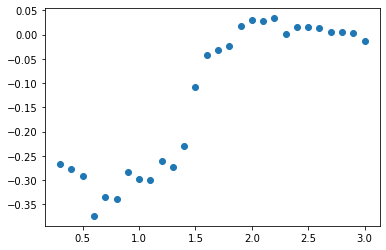

In [120]:
plt.scatter(np.arange(0.3, 3.1, 0.1), corrs)

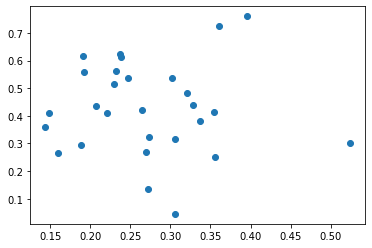

In [121]:
plt.scatter(cons, fqs_ssfr)

-0.2966344365301194


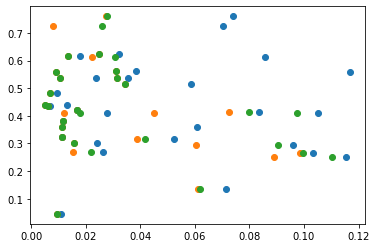

In [122]:
plt.scatter(fofs, fqs_ssfr)

plt.scatter(fofs15, fqs_ssfr)

plt.scatter(fofs1, fqs_ssfr)
print(np.corrcoef(fofs1, fqs_ssfr)[0, 1])

-0.2966344365301194


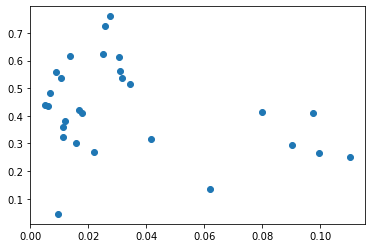

In [123]:
plt.scatter(fofs1, fqs_ssfr)
print(np.corrcoef(fofs1, fqs_ssfr)[0, 1])

-0.33381588589701805


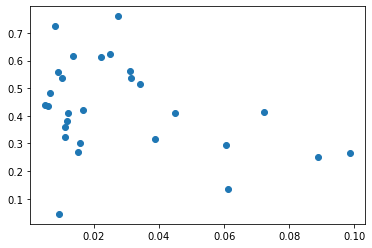

In [124]:
plt.scatter(fofs15, fqs_ssfr)
print(np.corrcoef(fofs15, fqs_ssfr)[0, 1])

total 2508 grid points
total 1364 grid points
total 2136 grid points
total 2438 grid points
total 1034 grid points
total 1078 grid points
total 1606 grid points
total 916 grid points
total 3228 grid points
total 2946 grid points
total 2495 grid points
total 707 grid points
total 3650 grid points
total 2961 grid points
total 617 grid points
total 1946 grid points
total 619 grid points
total 916 grid points
total 3370 grid points
total 201 grid points


/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


total 1997 grid points
total 1212 grid points
total 1265 grid points
total 578 grid points
total 1048 grid points
total 1107 grid points
total 1438 grid points
total 779 grid points


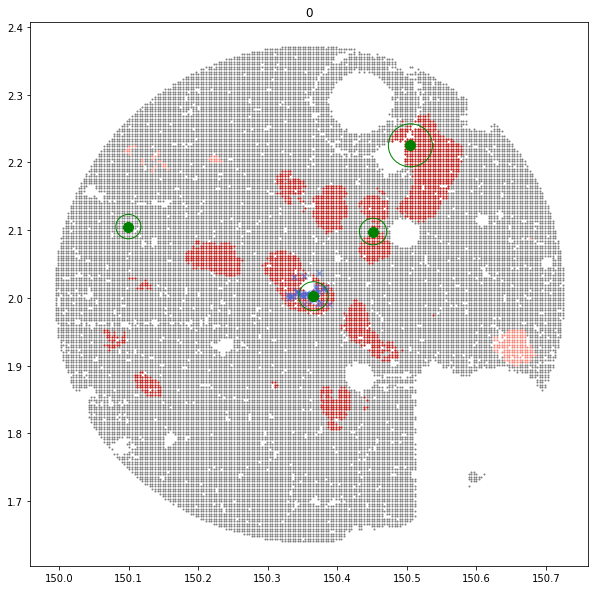

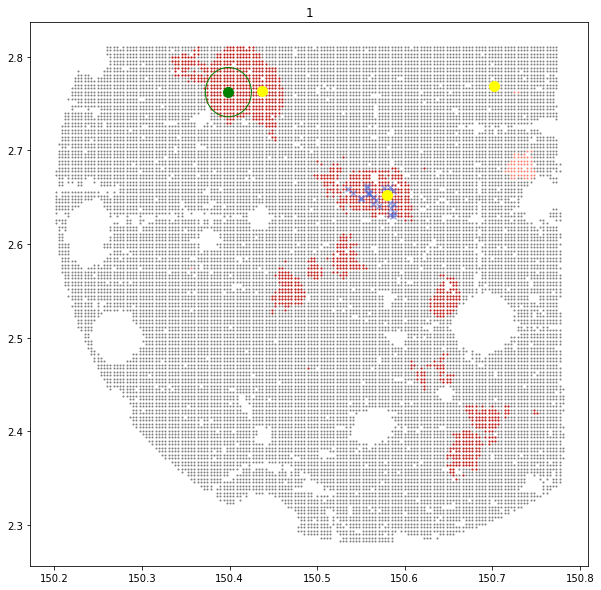

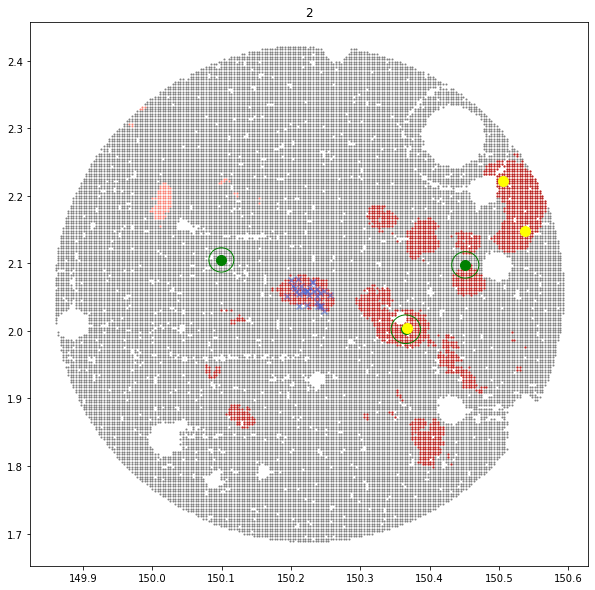

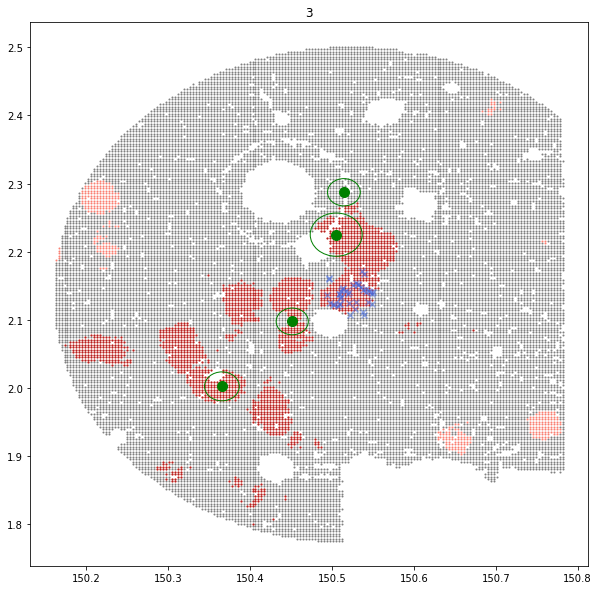

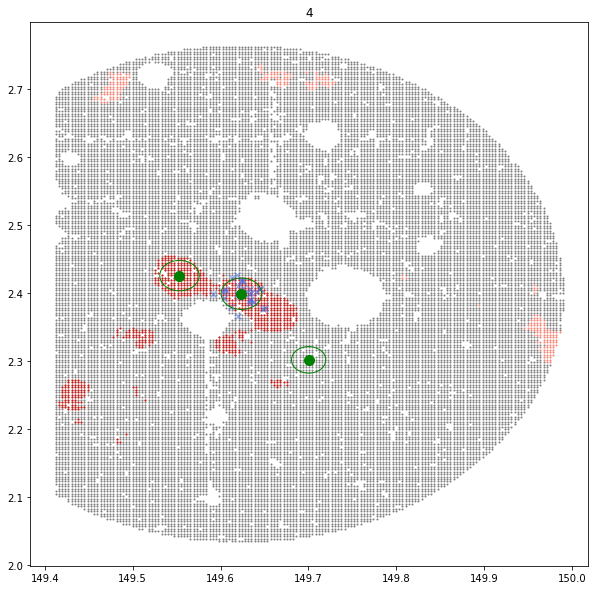

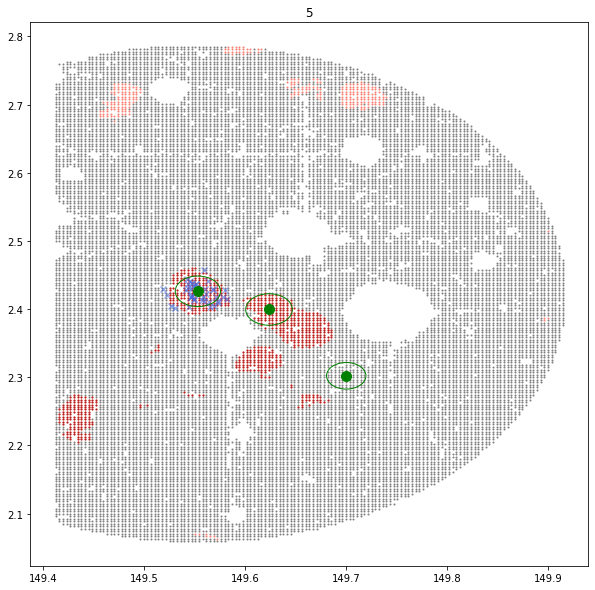

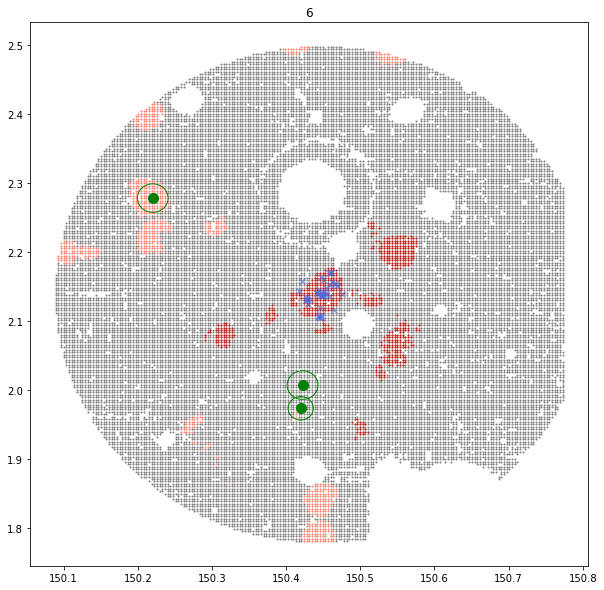

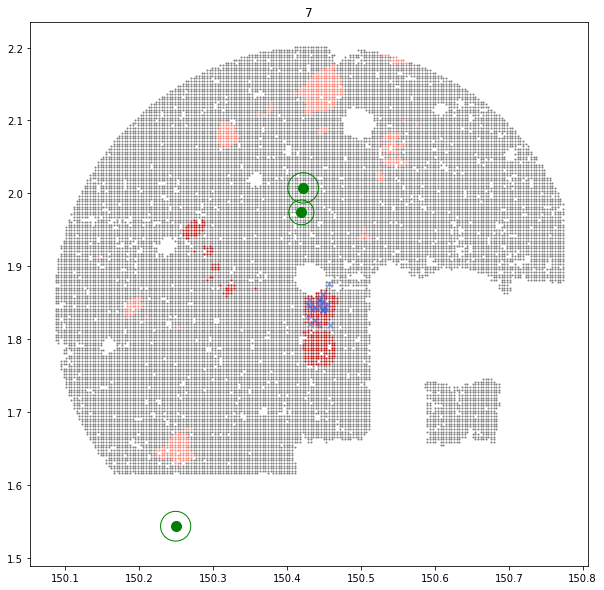

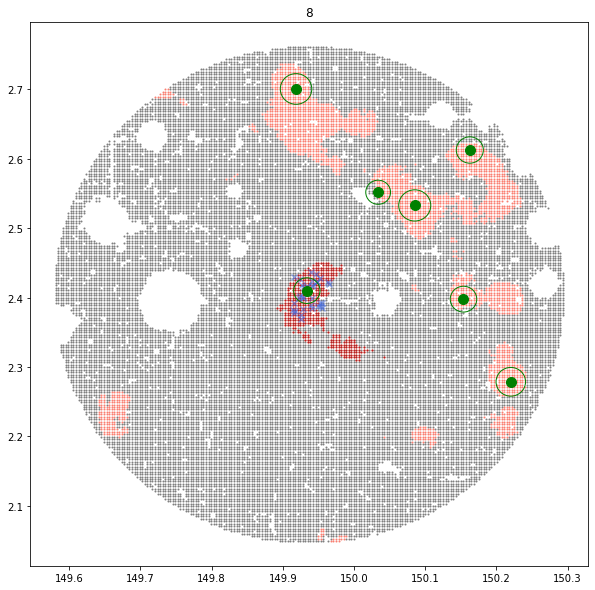

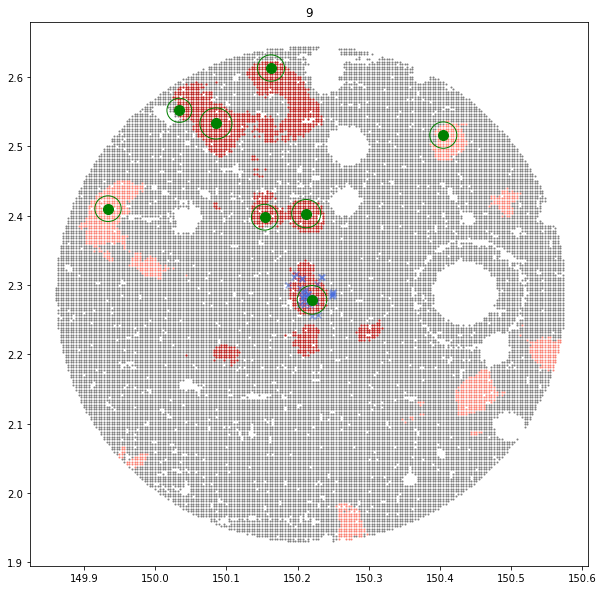

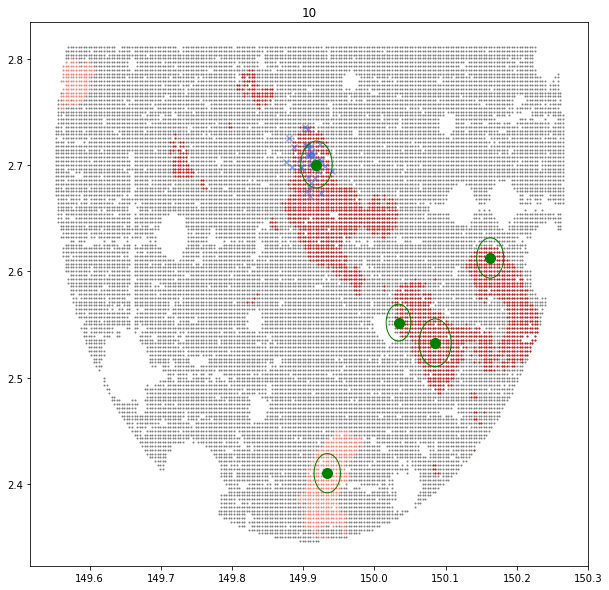

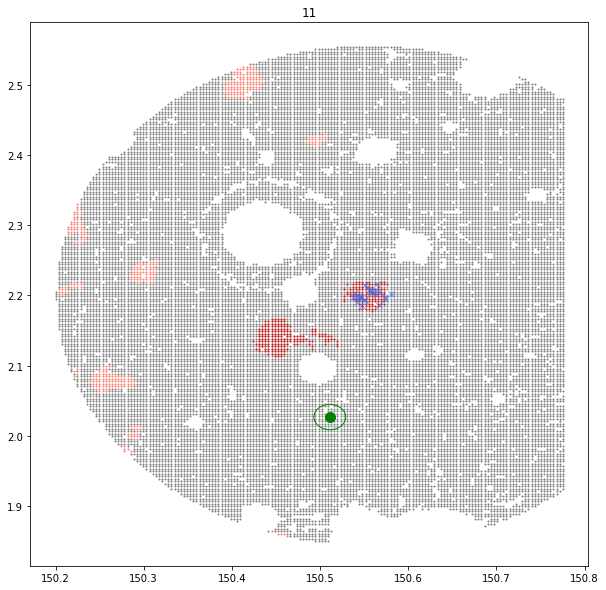

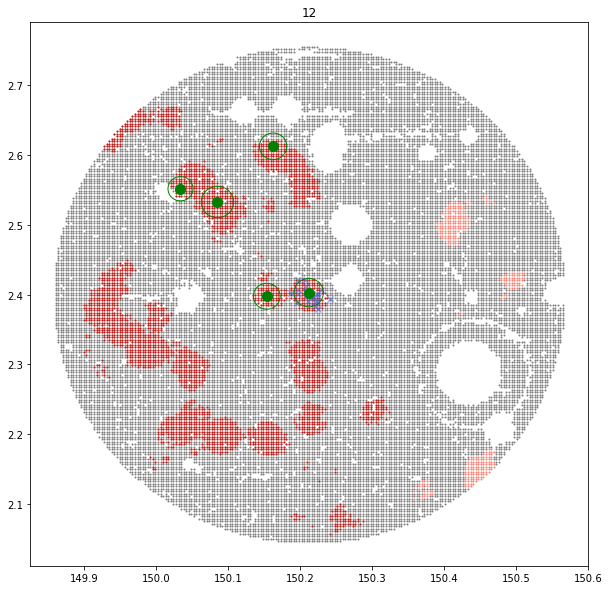

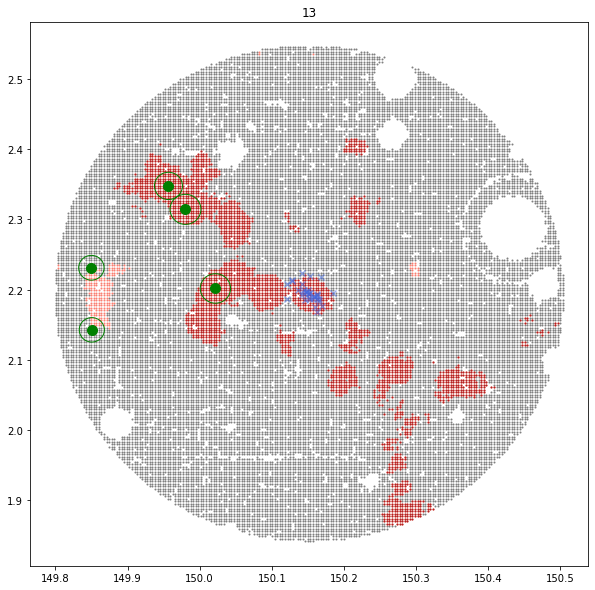

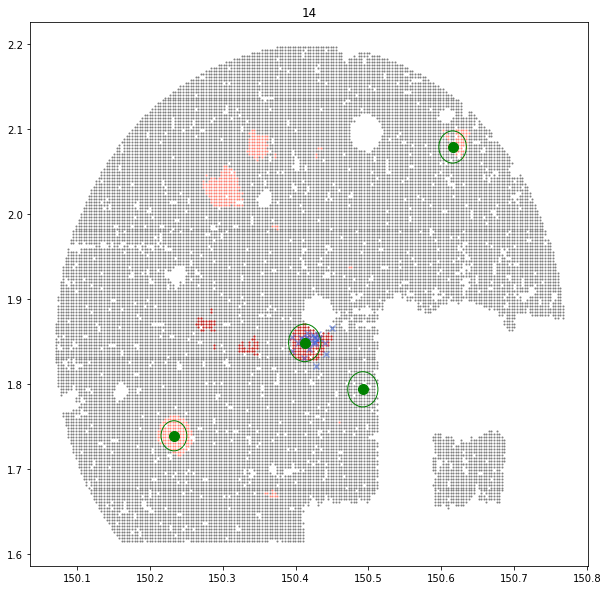

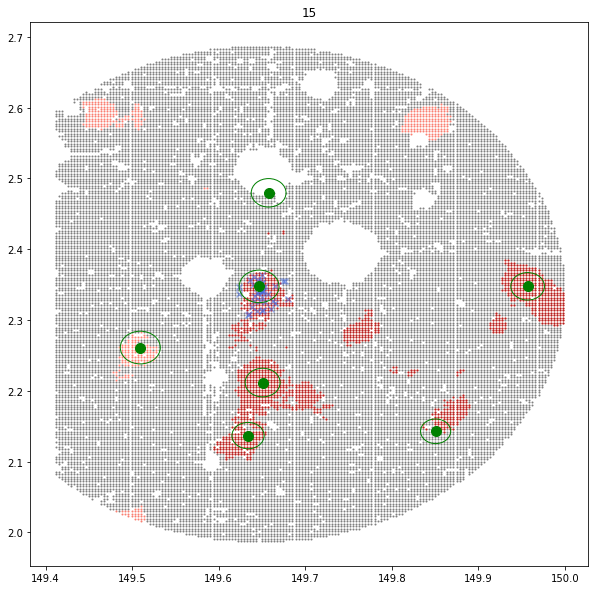

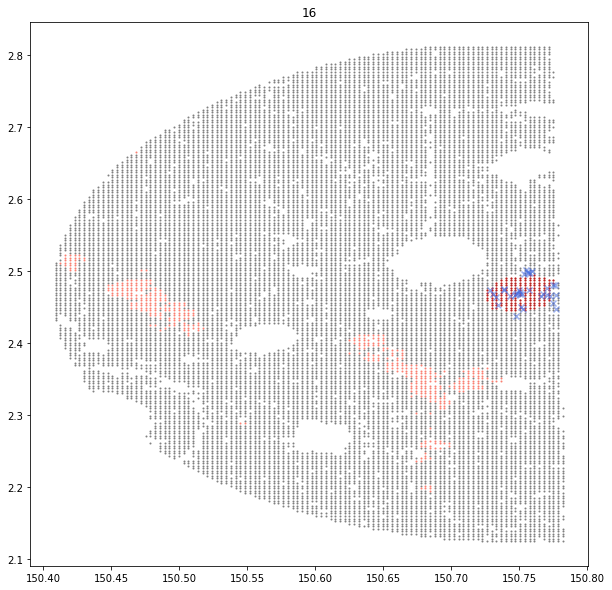

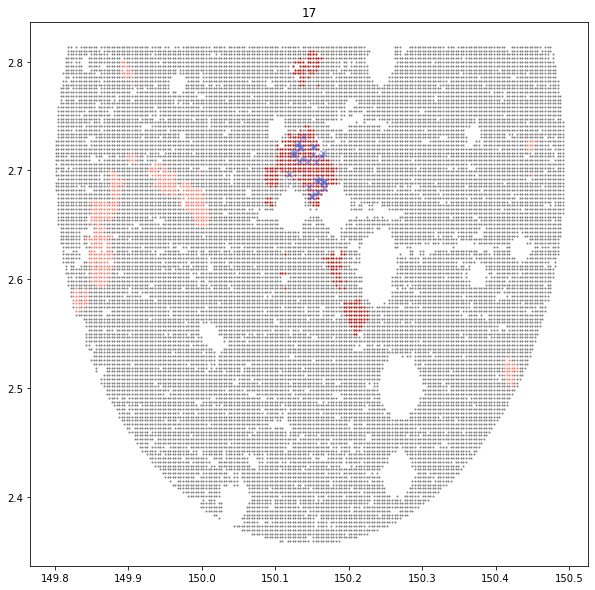

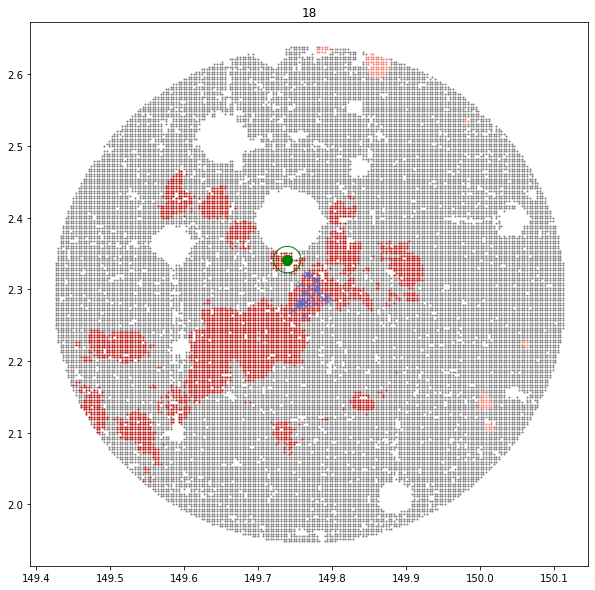

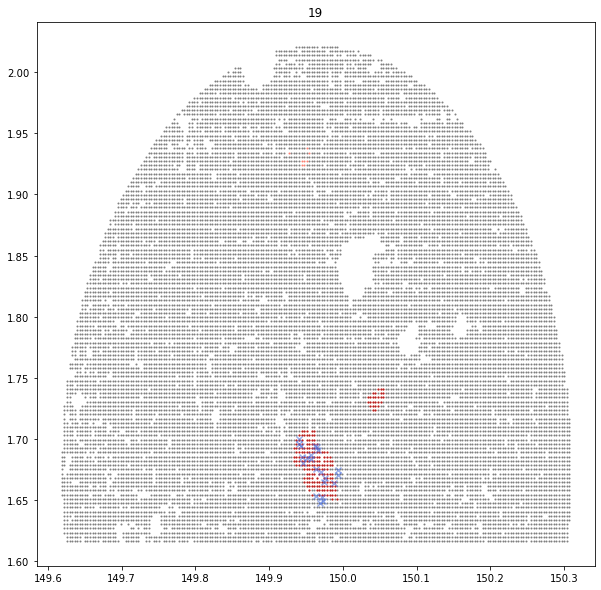

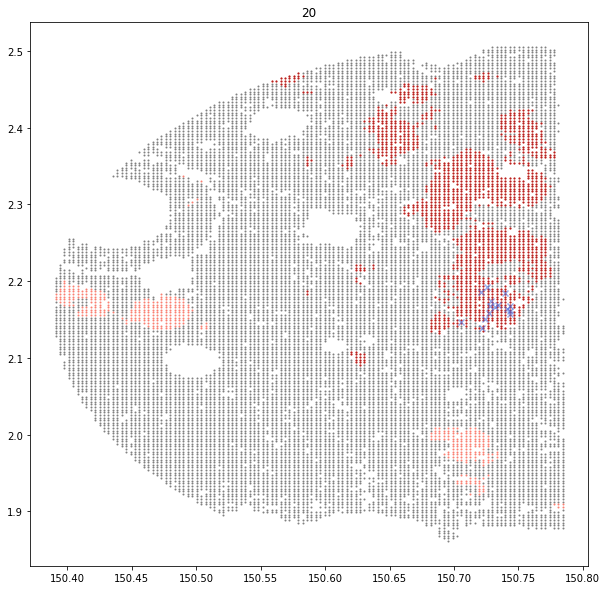

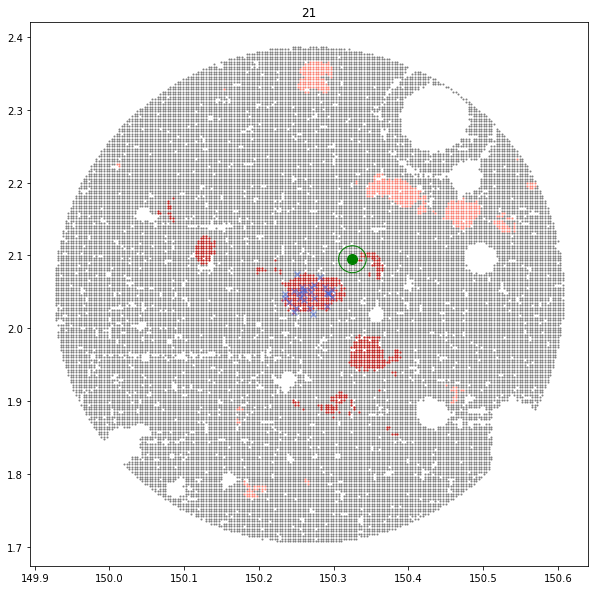

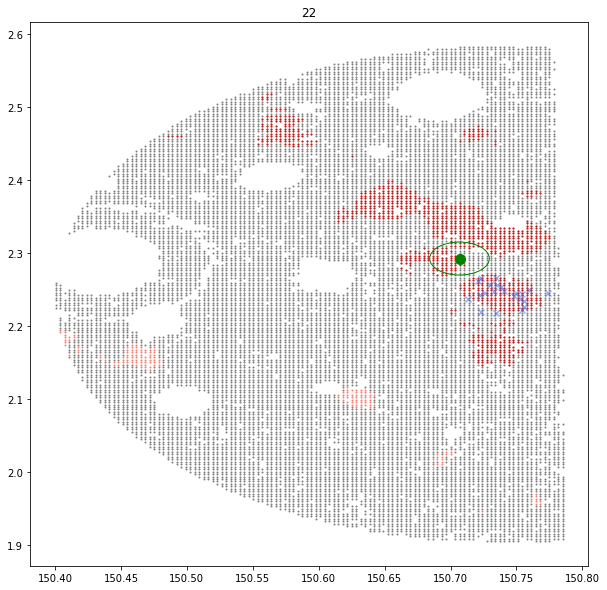

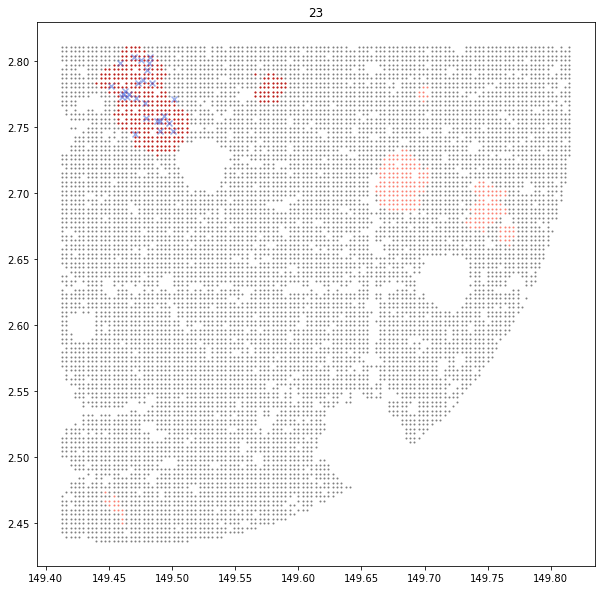

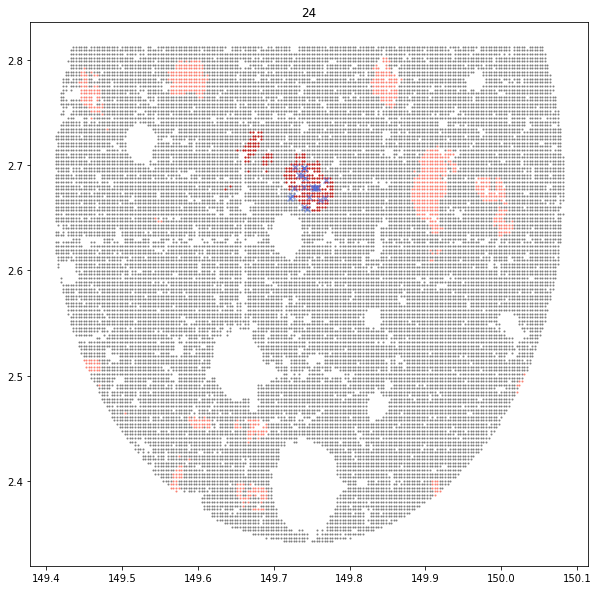

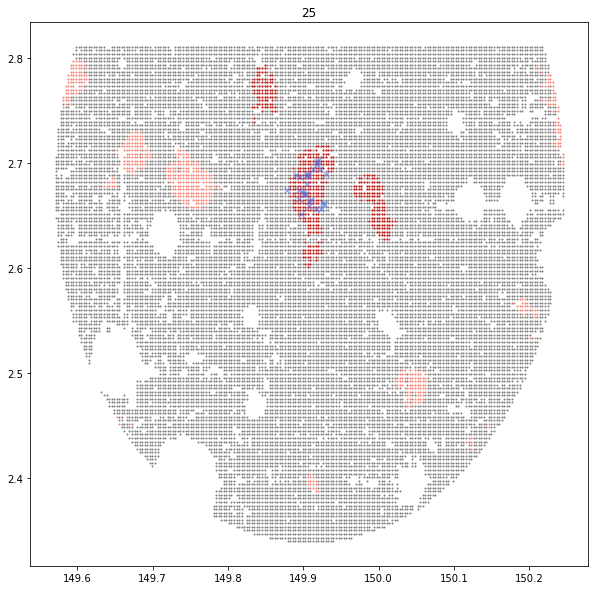

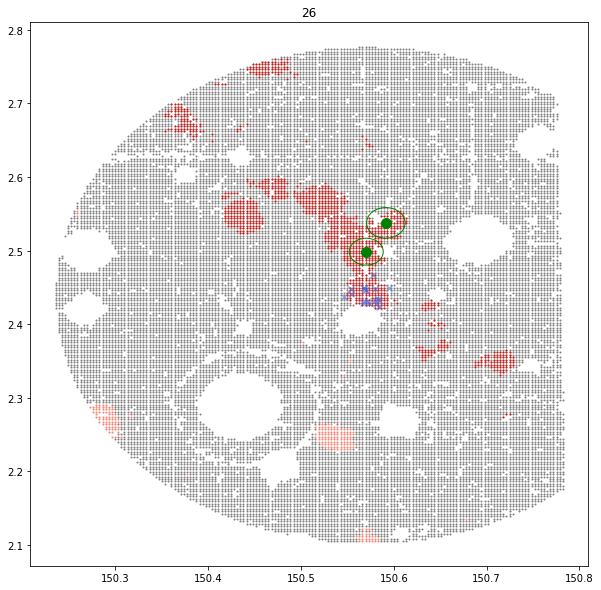

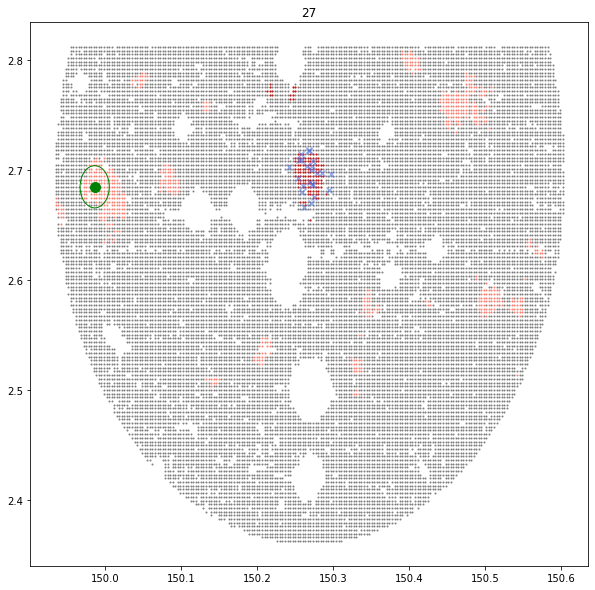

In [125]:
for i in range(len(ods)):
    mmask = total_pd['Seq'].isin(ods[i])
    
    mems = total_pd[mmask]
    z = np.mean(mems['zphot'])
    
    z_index = np.argmin((redshifts - z)**2) 
    
    grid = np.load('./bins/bins_cosmos/search_700kpc/' + file_list[z_index])
    mask1 = np.load('./bins/bins_cosmos/search_700kpc/mask1_10/' + mask1_list[z_index])
    mask2 = np.load('./bins/bins_cosmos/search_700kpc/mask2_10/' + mask2_list[z_index])

    grid_x = np.load('./bins/bins_cosmos/search_700kpc/grid_x/' + xlist[z_index])
    grid_y = np.load('./bins/bins_cosmos/search_700kpc/grid_y/' + ylist[z_index])
    
    grid_1d = grid[mask1 & mask2]

    mean = grid_1d.mean()
    std = grid_1d.std()

    overdense_mask2 = grid > mean + 2 * std
    sparse_mask2 = grid < mean + 2 * std
    
    grid_od = (grid - mean) / std

    search = find_radius(z, 10)
    area_mask = ((grid_x - np.mean(mems['RAJ2000']))**2 + (grid_y - np.mean(mems['DEJ2000']))**2 < search**2)
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.scatter(grid_x[mask1 & mask2 & area_mask&sparse_mask2], grid_y[mask1 & mask2 & area_mask& sparse_mask2], color = 'grey', s = 1)
    ax.scatter(grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask& overdense_mask2], color = 'salmon', s = 1)
    
    ax.set_title(f'{i}')
    
    findex = find_fofs(np.mean(mems['RAJ2000']), np.mean(mems['DEJ2000']), grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask&overdense_mask2], z_index, 2)    
    

    fof = len(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex]) / len(grid_x[mask1 & mask2 & area_mask])
    ax.scatter(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex], grid_y[mask1 & mask2 & area_mask & overdense_mask2][findex], color = 'firebrick', alpha = 1, s = 1)

    ax.scatter(mems['RAJ2000'], mems['DEJ2000'], color = 'royalblue', marker = 'x', alpha = .5)
    
    xzmask = (x_new['redshift'] >= z- 0.02) & (x_new['redshift'] <= z + 0.02)
    xmask2 = (x_new['Ra'] - np.mean(mems['RAJ2000']))**2 + (x_new['Dec'] - np.mean(mems['DEJ2000']))**2 < search**2
    xsample = x_new[xzmask & xmask2]
    for k in range(len(xsample)):

        ax.scatter(xsample['Ra'][k], xsample['Dec'][k], s = 100, color = 'green')
        circle = plt.Circle((xsample['Ra'][k], xsample['Dec'][k]), xsample['R200_deg'][k], fill = False, color = 'green')
        ax.add_patch(circle)
    
    bzmask = (bellagamba['z'] >= z - 0.02) & (bellagamba['z'] <= z + 0.02)
    bmask2 = (bellagamba['RAJ2000'] - np.mean(mems['RAJ2000']))**2 + (bellagamba['DEJ2000'] - np.mean(mems['DEJ2000']))**2 < search**2
    bsample = bellagamba[bzmask & bmask2]
    ax.scatter(bsample['RAJ2000'], bsample['DEJ2000'], s = 100, color = 'yellow')
    
    plt.savefig(f'candidates/members/figures/od{i}.png')
    

total 2508 grid points
total 2508 grid points
total 1364 grid points
total 1364 grid points
total 2136 grid points
total 2136 grid points
total 2438 grid points
total 2438 grid points
total 1034 grid points
total 1034 grid points
total 1078 grid points
total 1078 grid points
total 1606 grid points
total 1606 grid points
total 916 grid points
total 916 grid points
total 3228 grid points
total 3228 grid points
total 2946 grid points
total 2946 grid points
total 2495 grid points
total 2495 grid points
total 707 grid points
total 707 grid points
total 3650 grid points
total 3650 grid points
total 2961 grid points
total 2961 grid points
total 617 grid points
total 617 grid points
total 1946 grid points
total 1946 grid points
total 619 grid points
total 619 grid points
total 916 grid points
total 916 grid points
total 3370 grid points
total 3370 grid points
total 201 grid points
total 201 grid points


/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


total 1997 grid points
total 1997 grid points
total 1212 grid points
total 1212 grid points
total 1265 grid points
total 1265 grid points
total 578 grid points
total 578 grid points
total 1048 grid points
total 1048 grid points
total 1107 grid points
total 1107 grid points
total 1438 grid points
total 1438 grid points
total 779 grid points
total 779 grid points


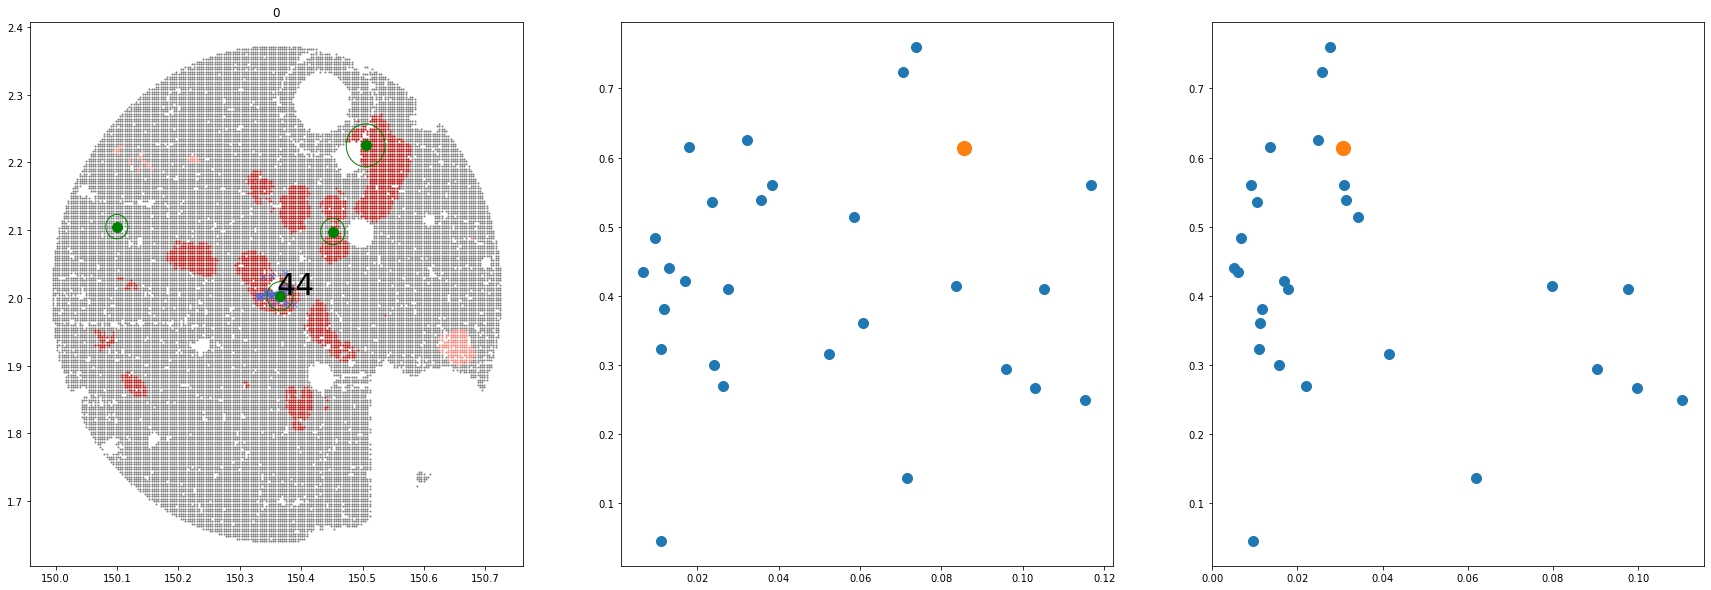

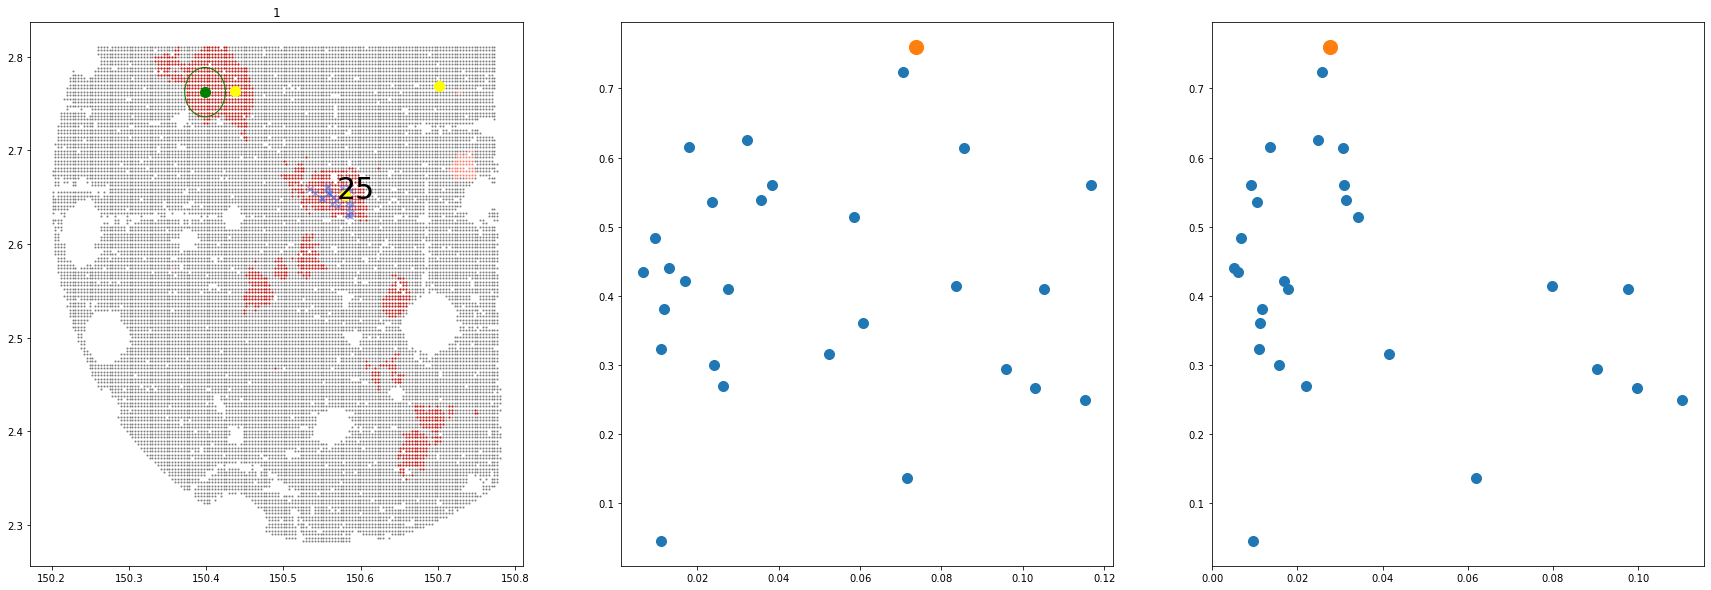

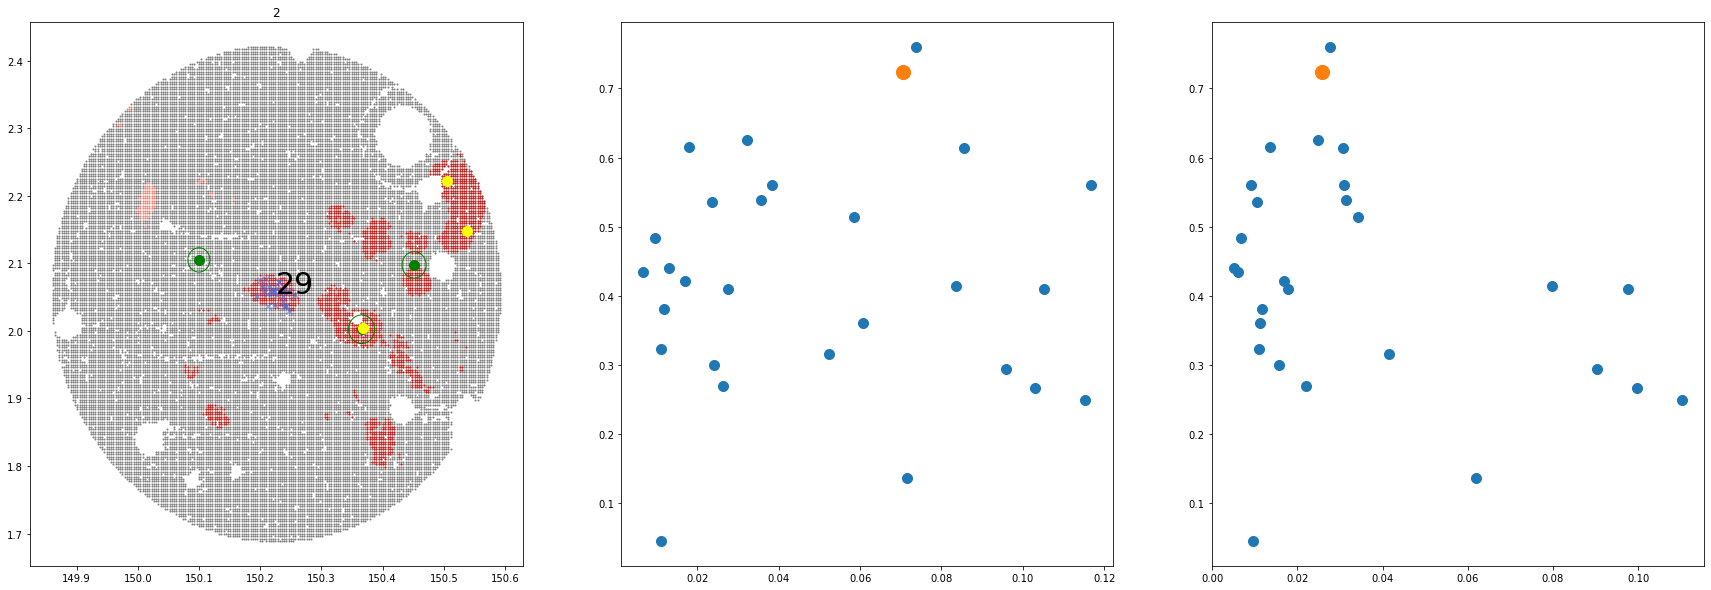

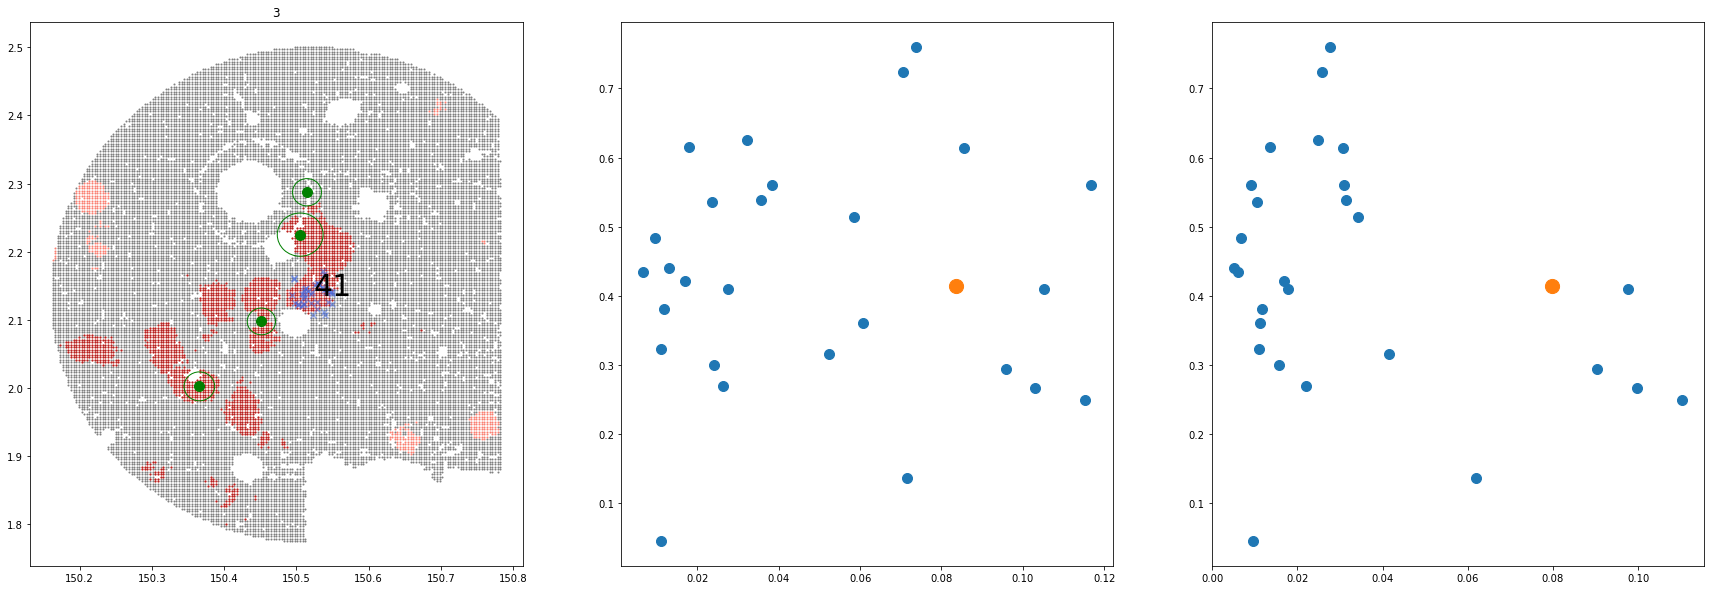

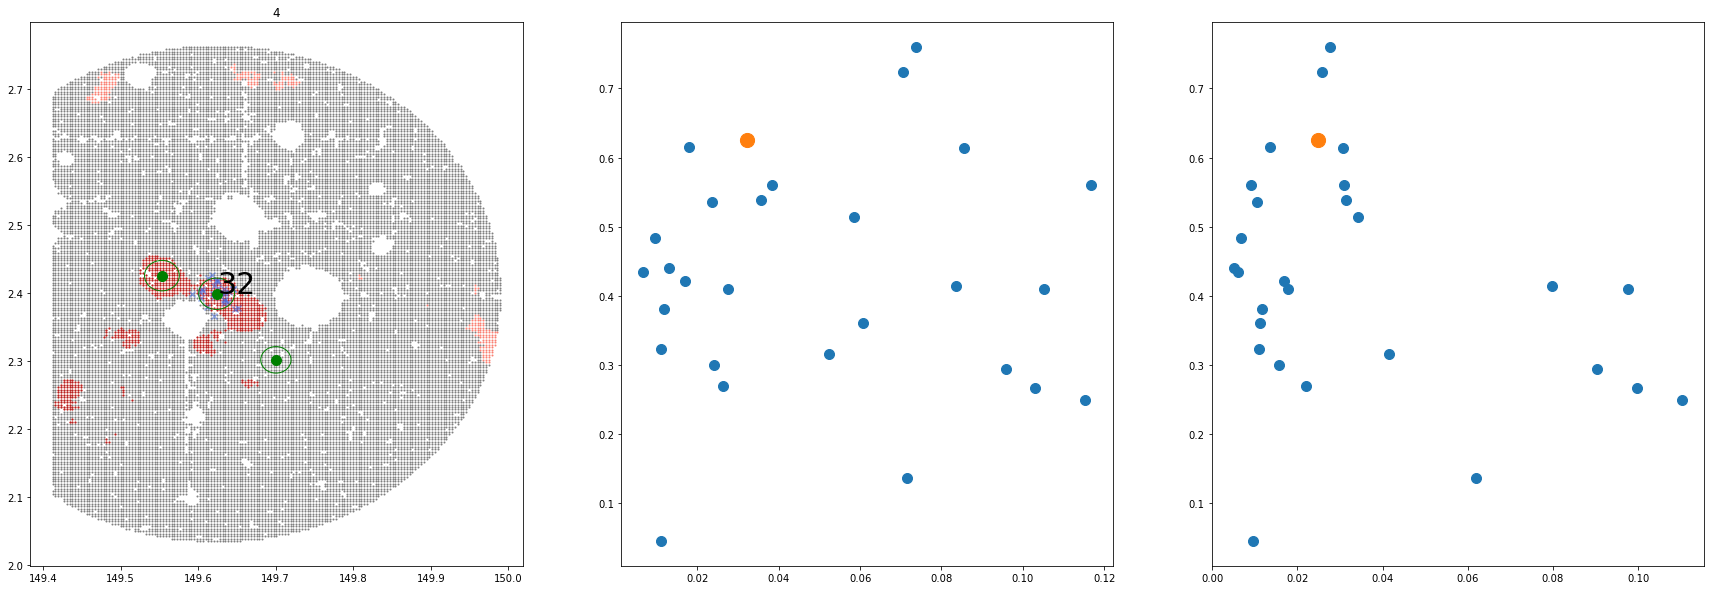

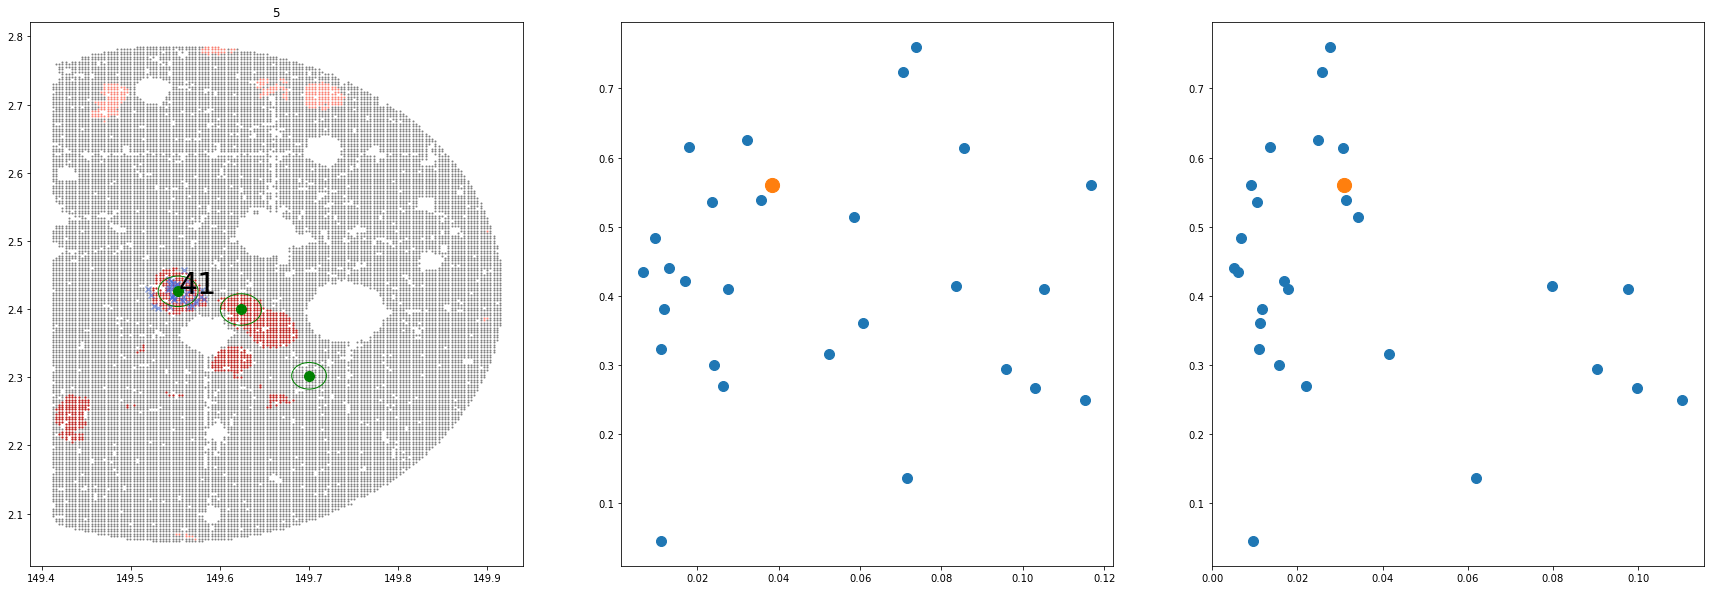

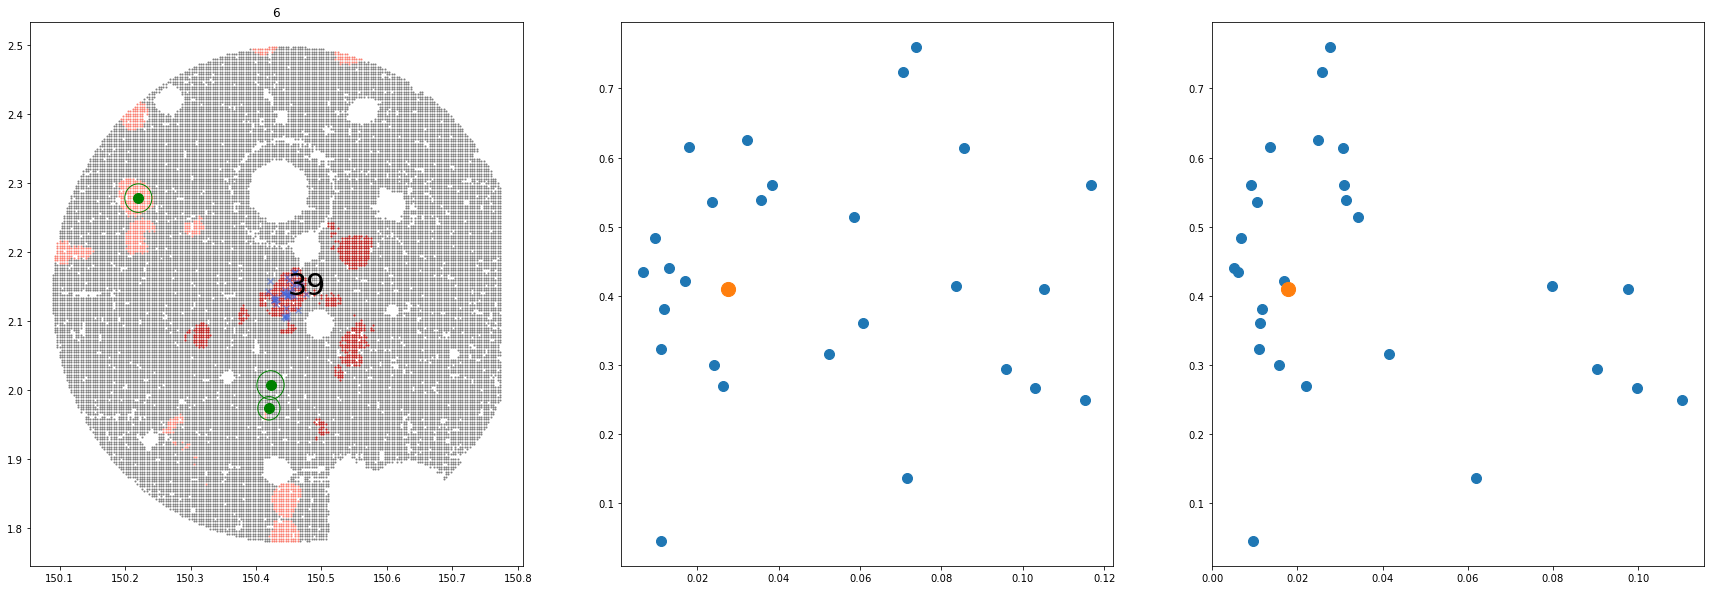

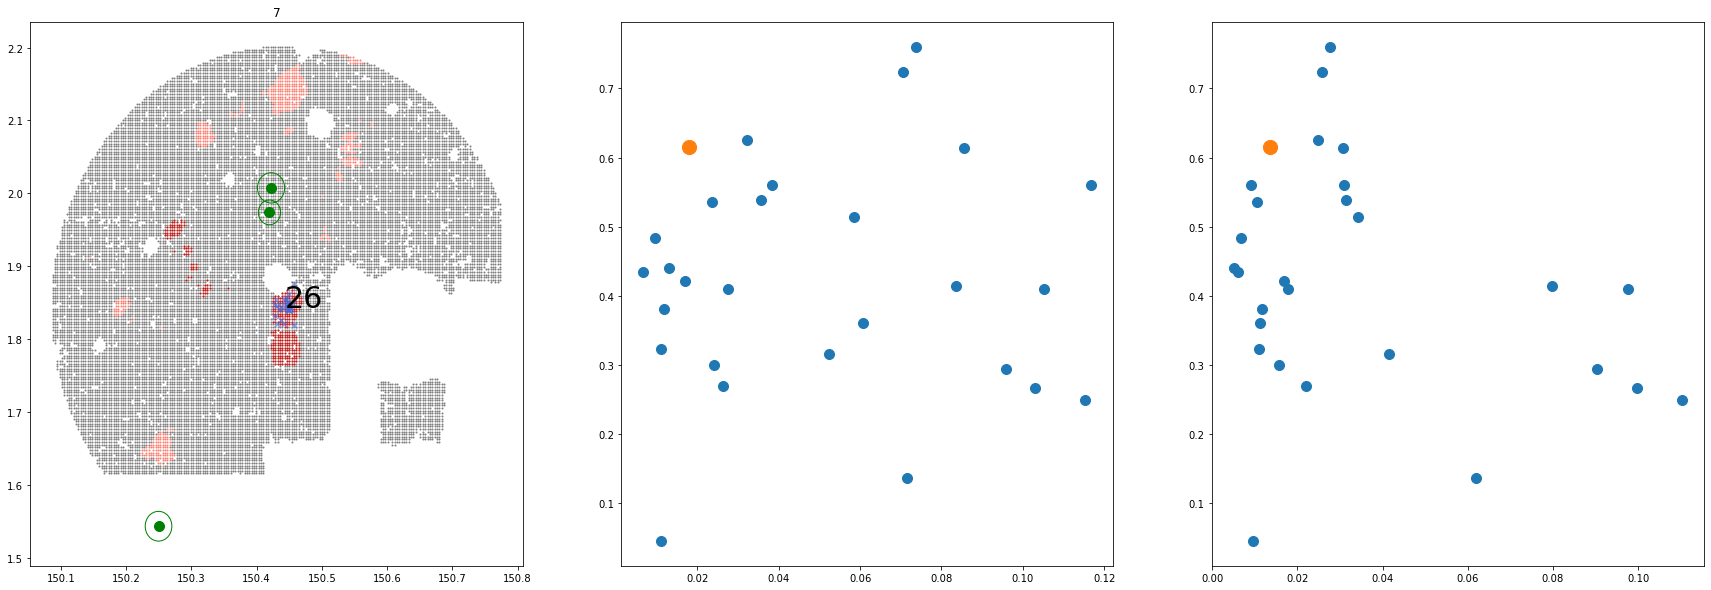

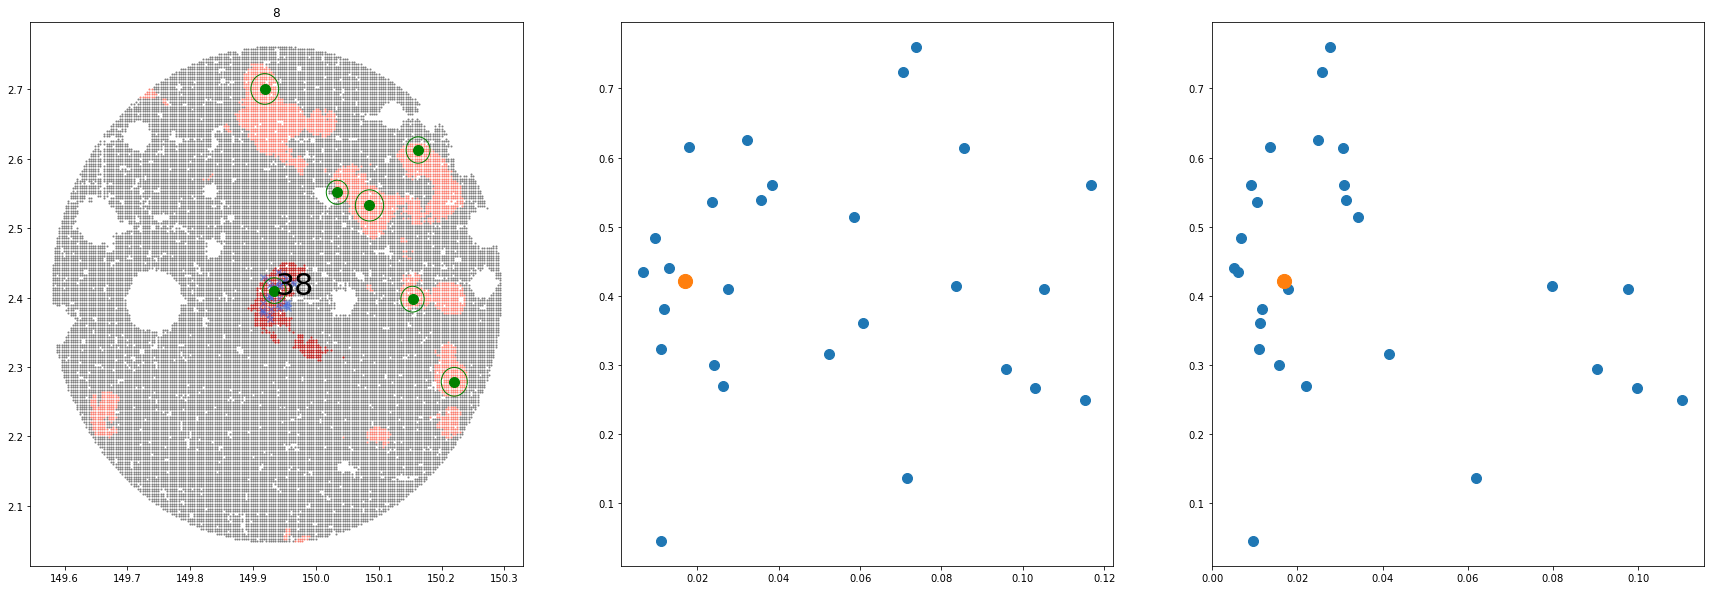

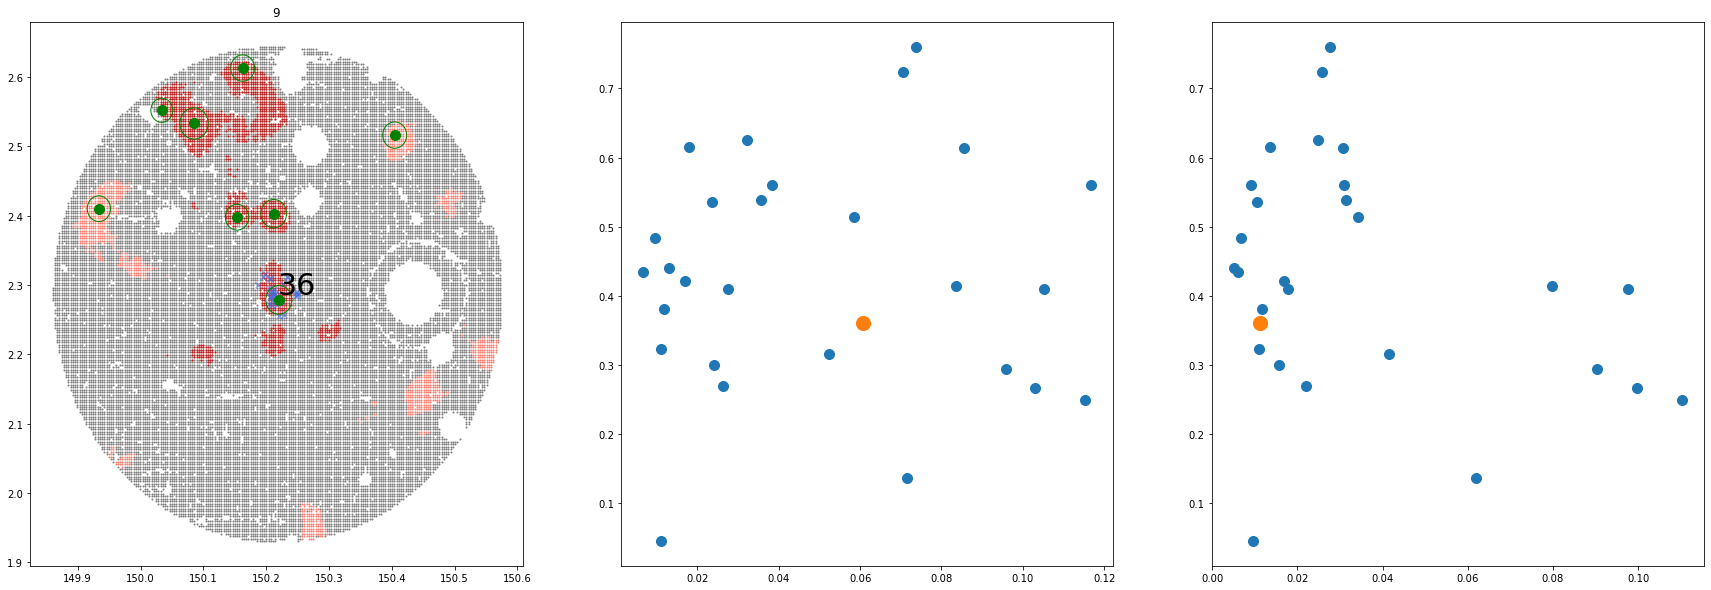

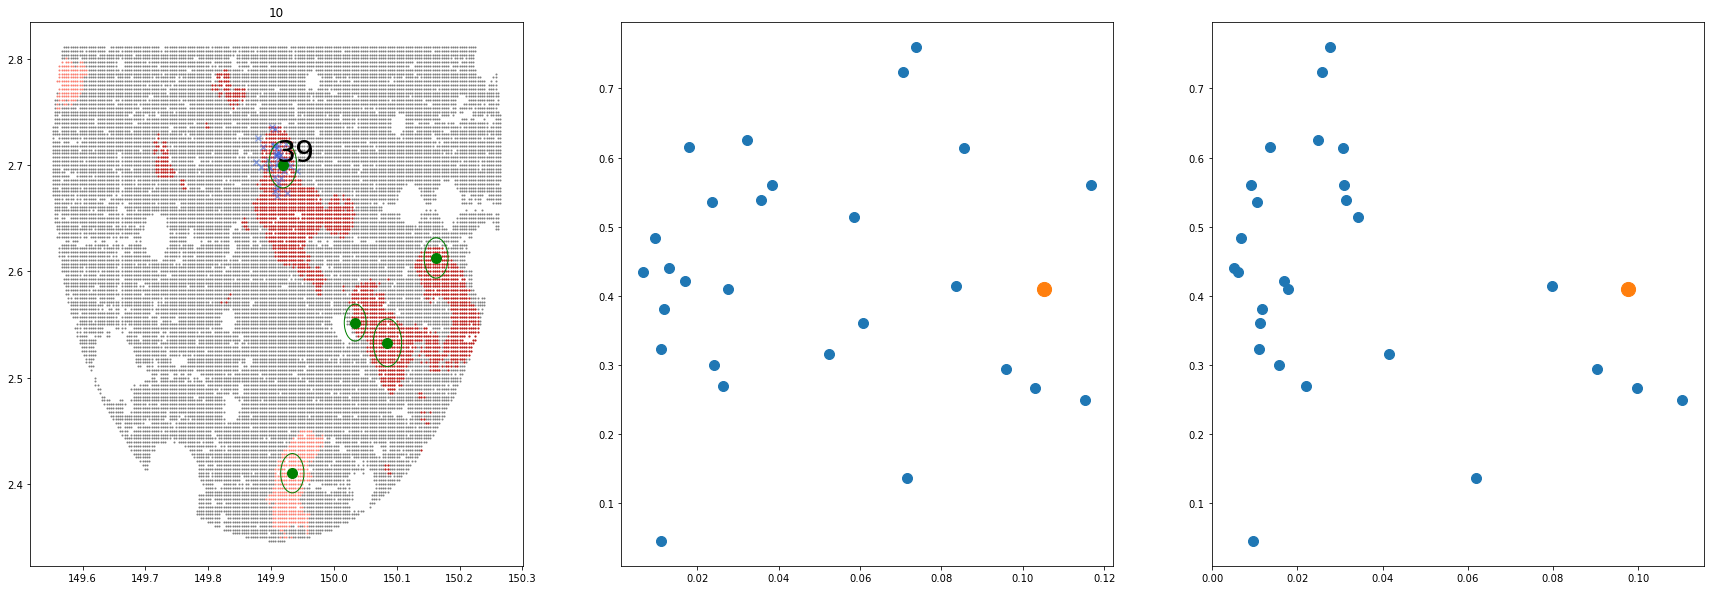

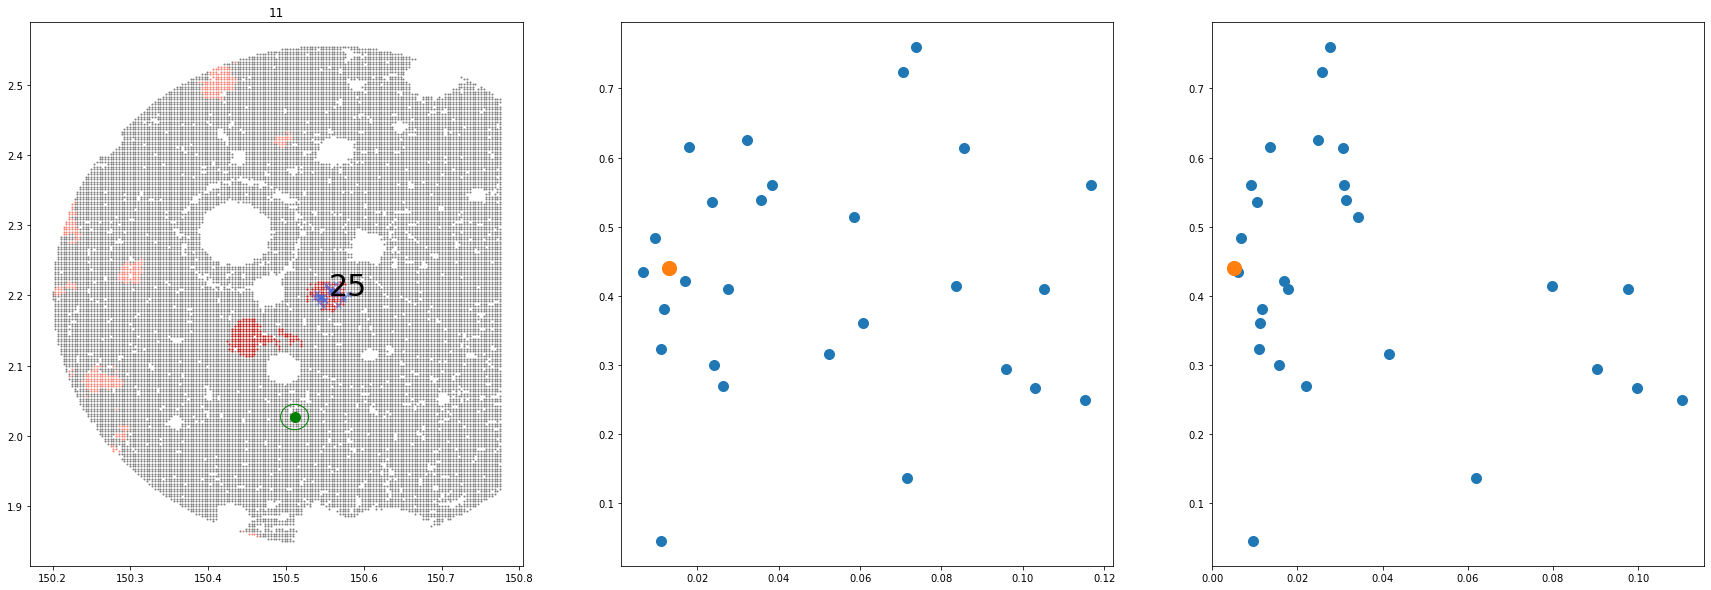

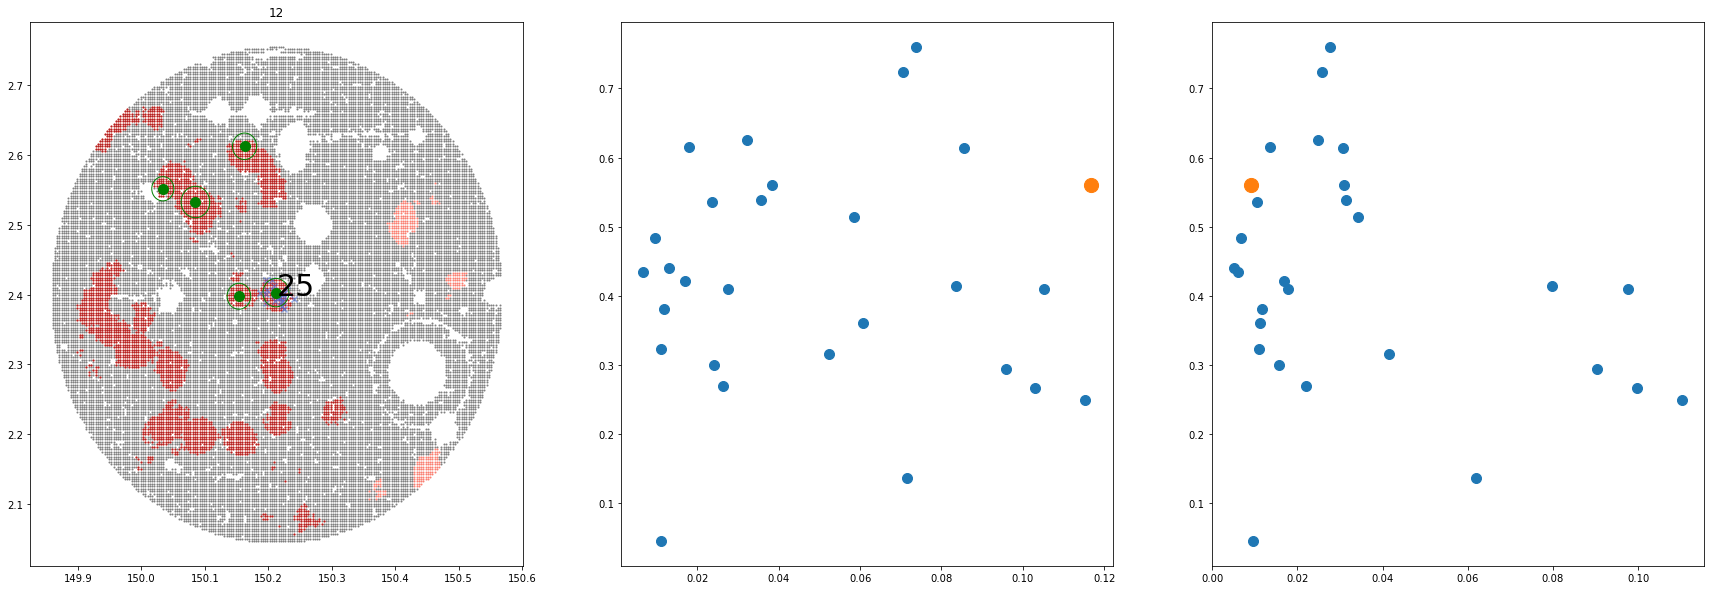

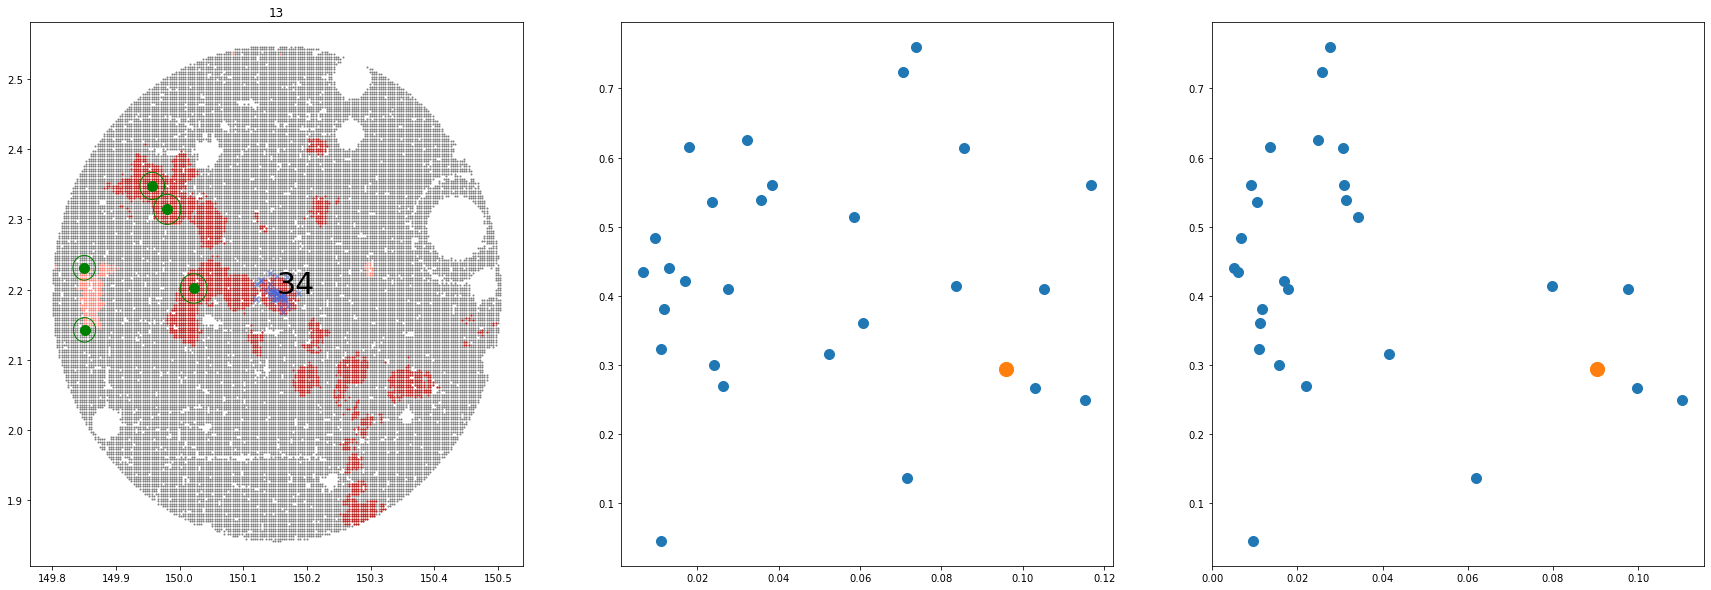

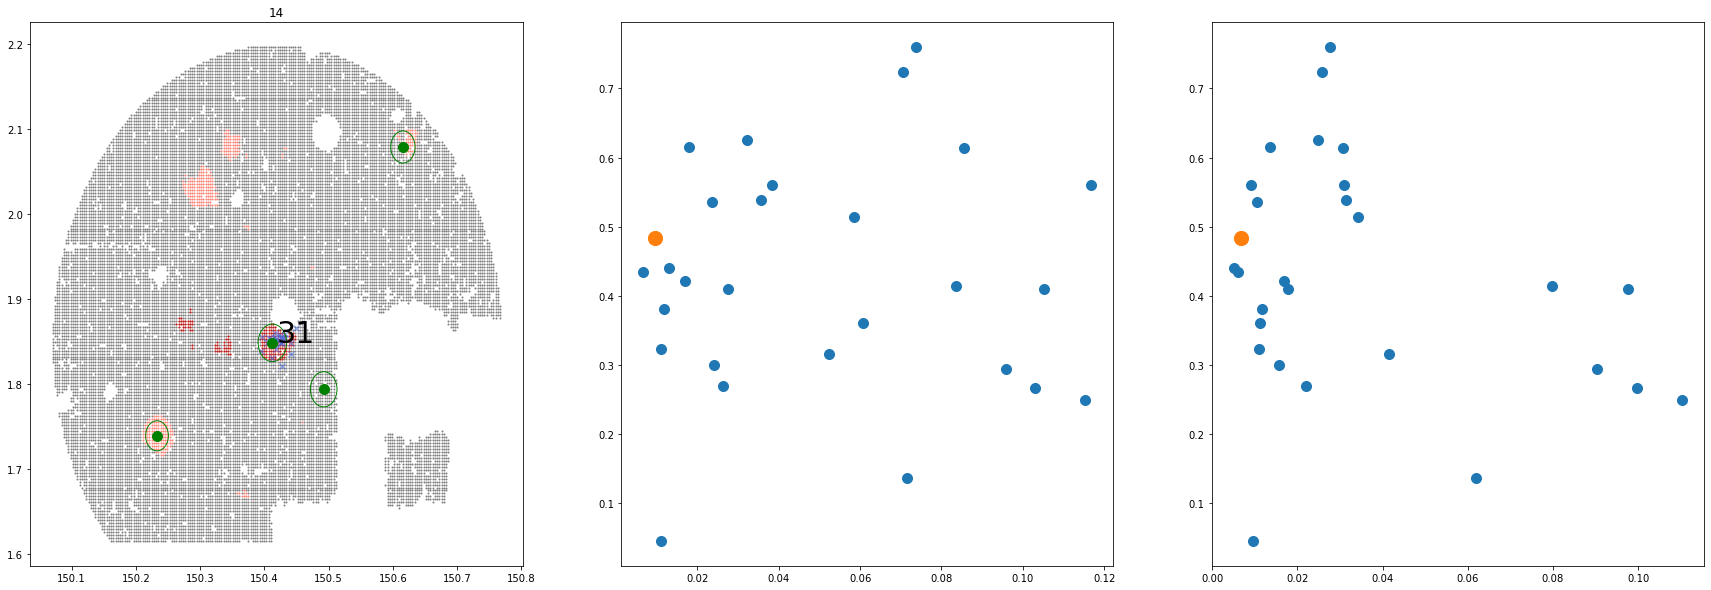

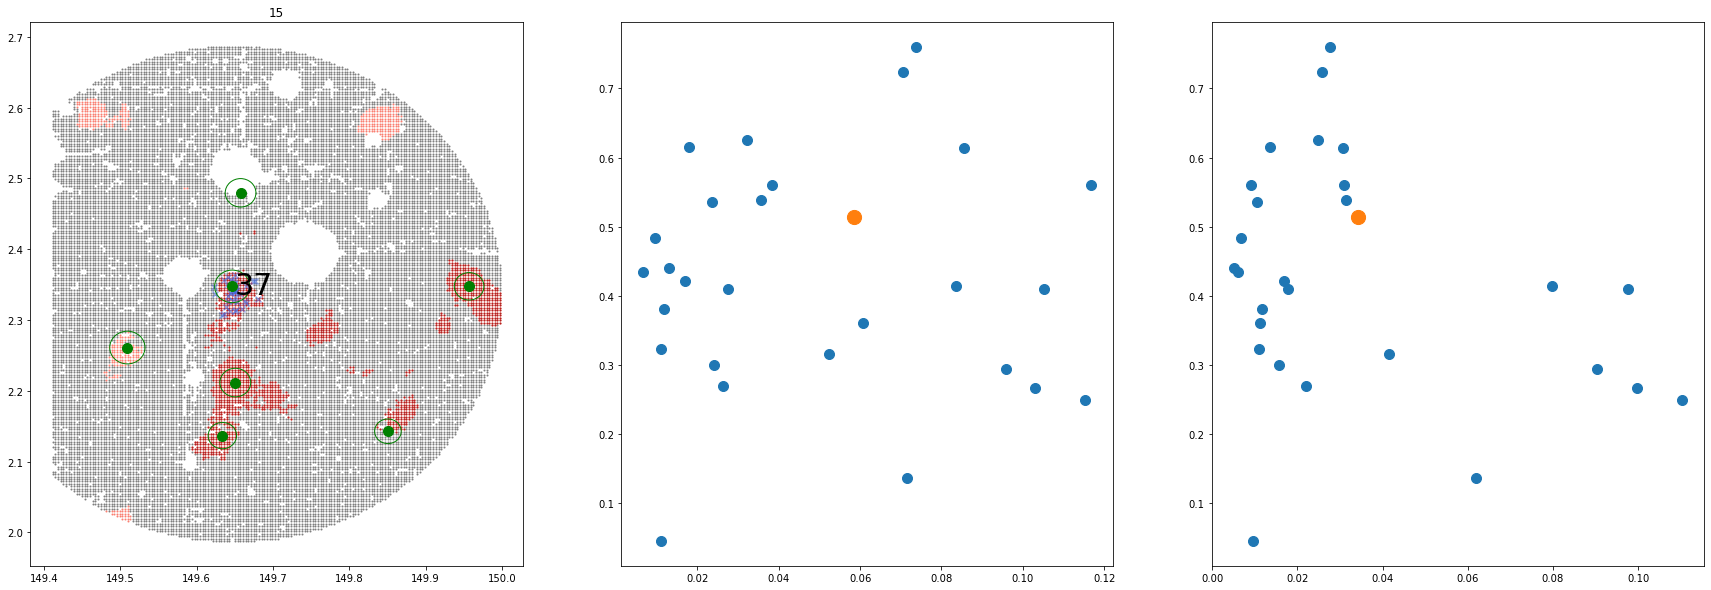

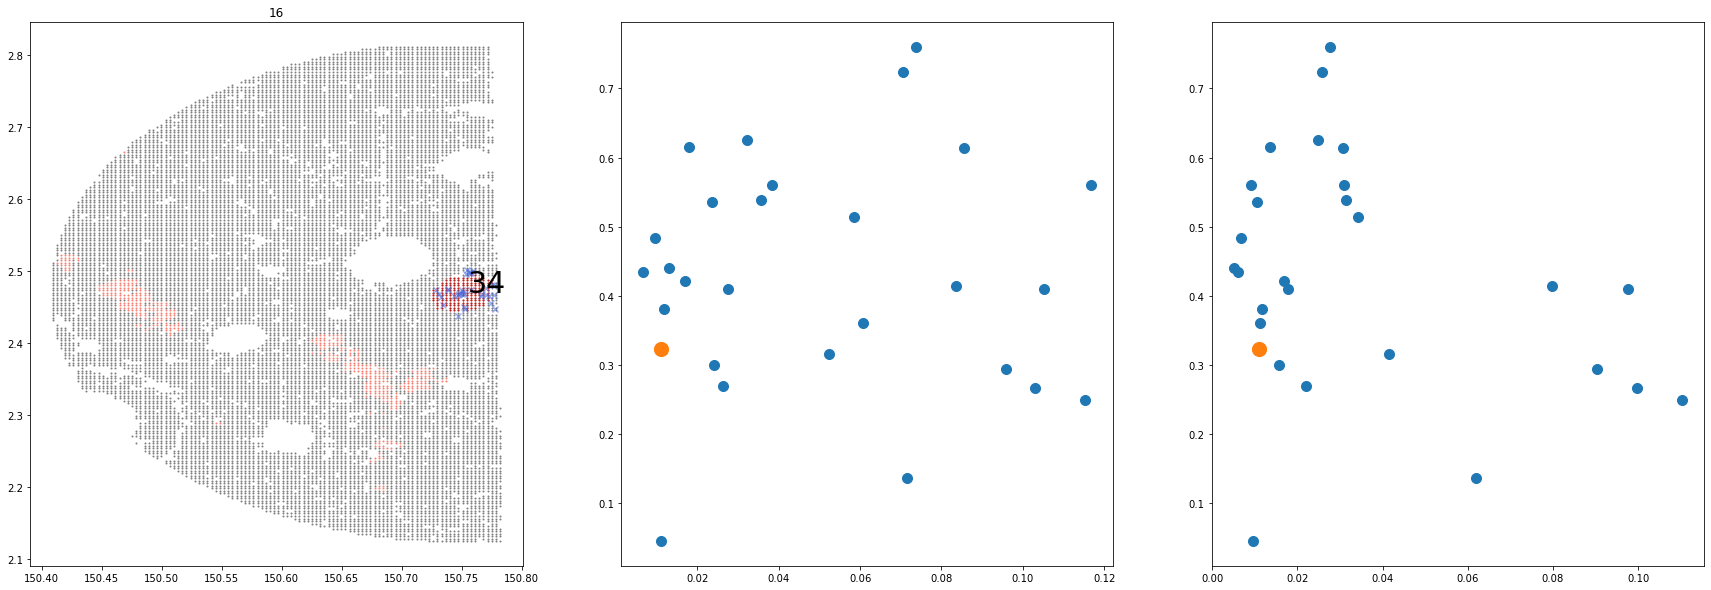

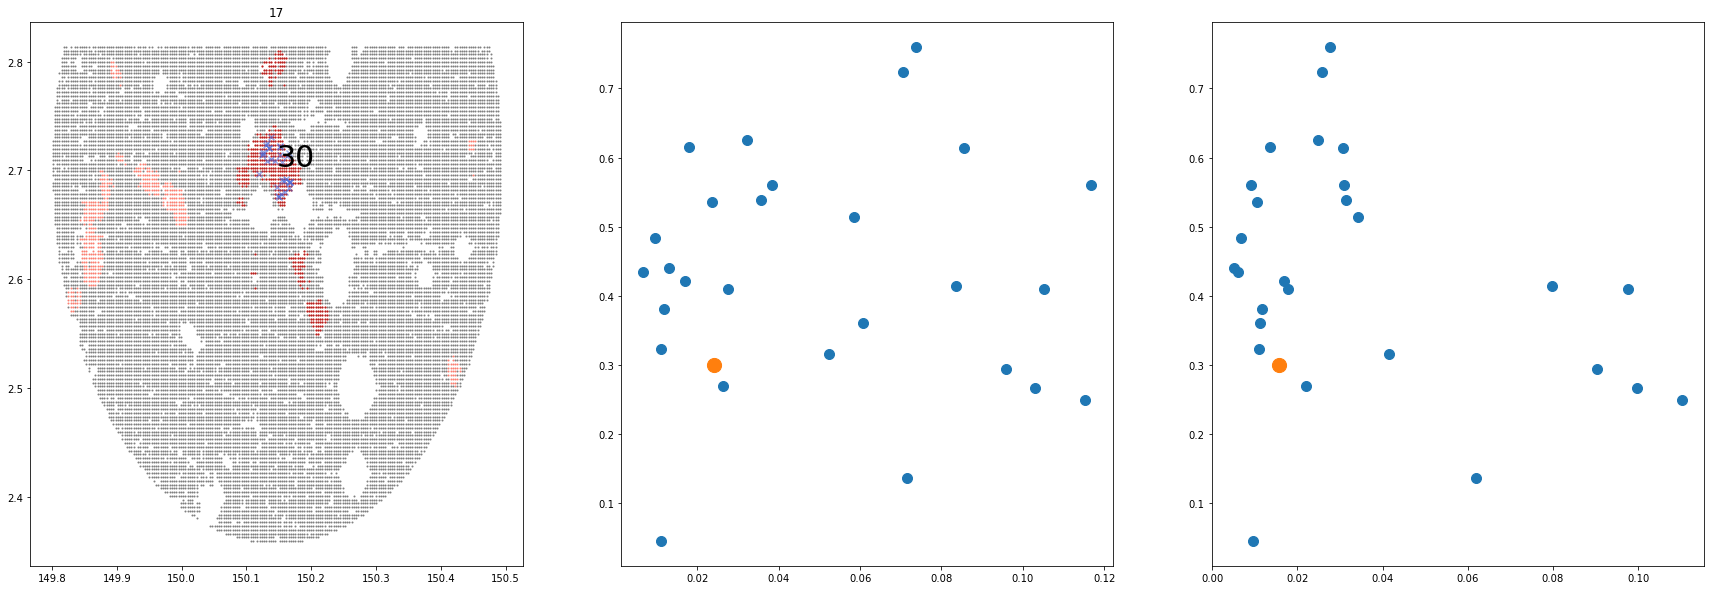

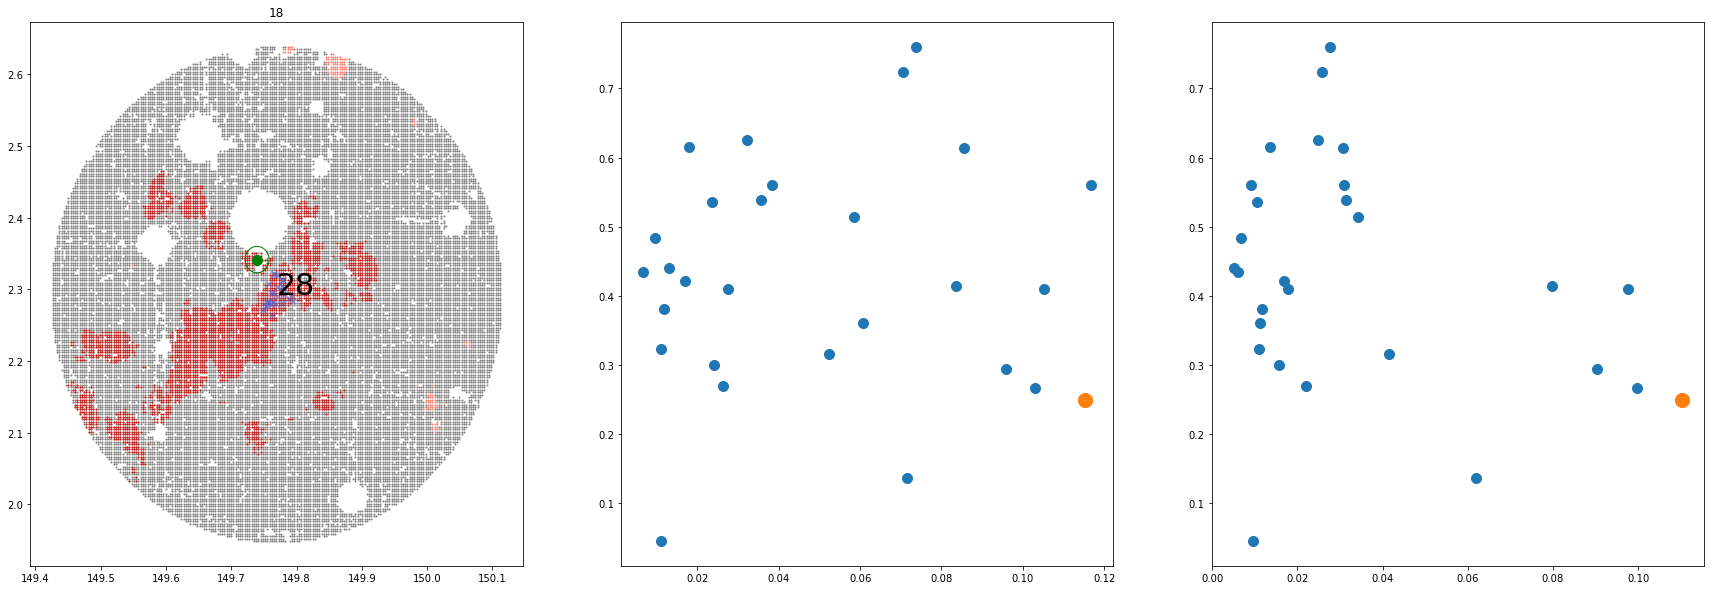

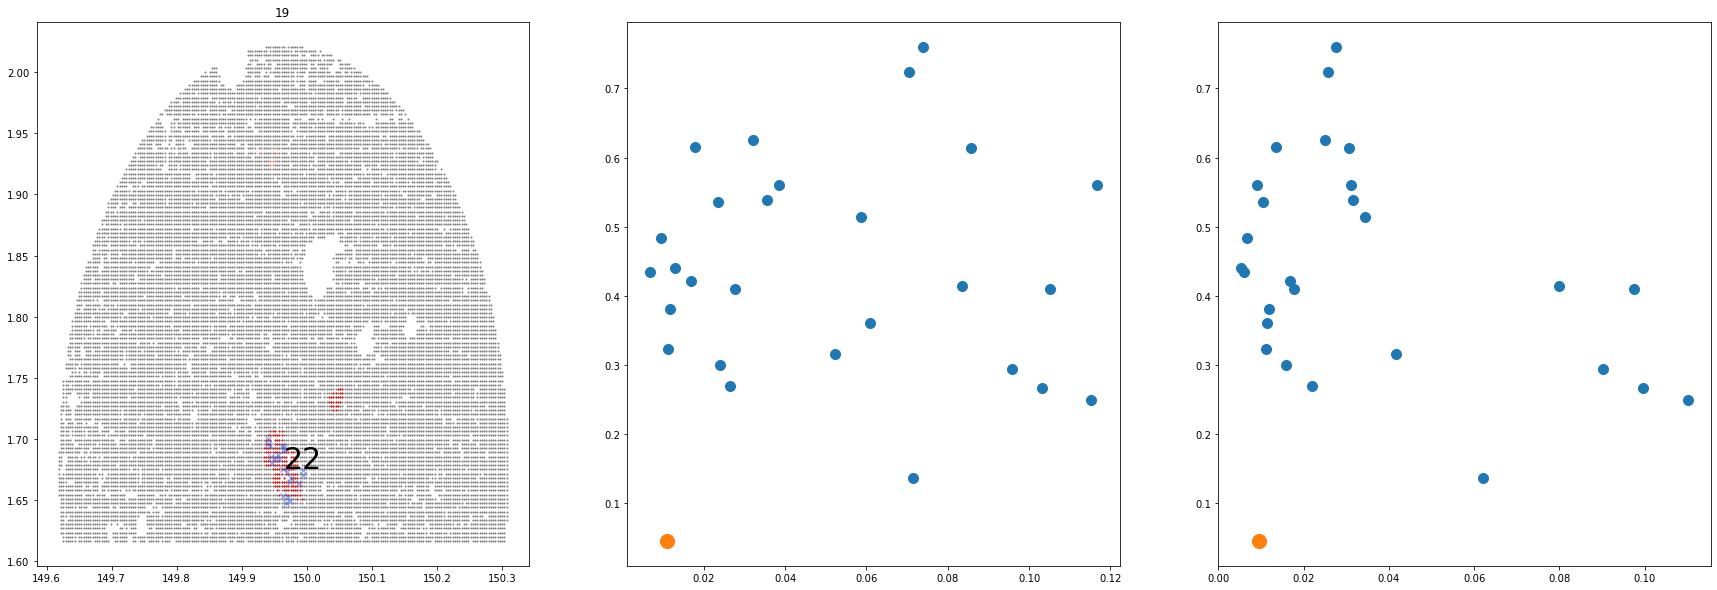

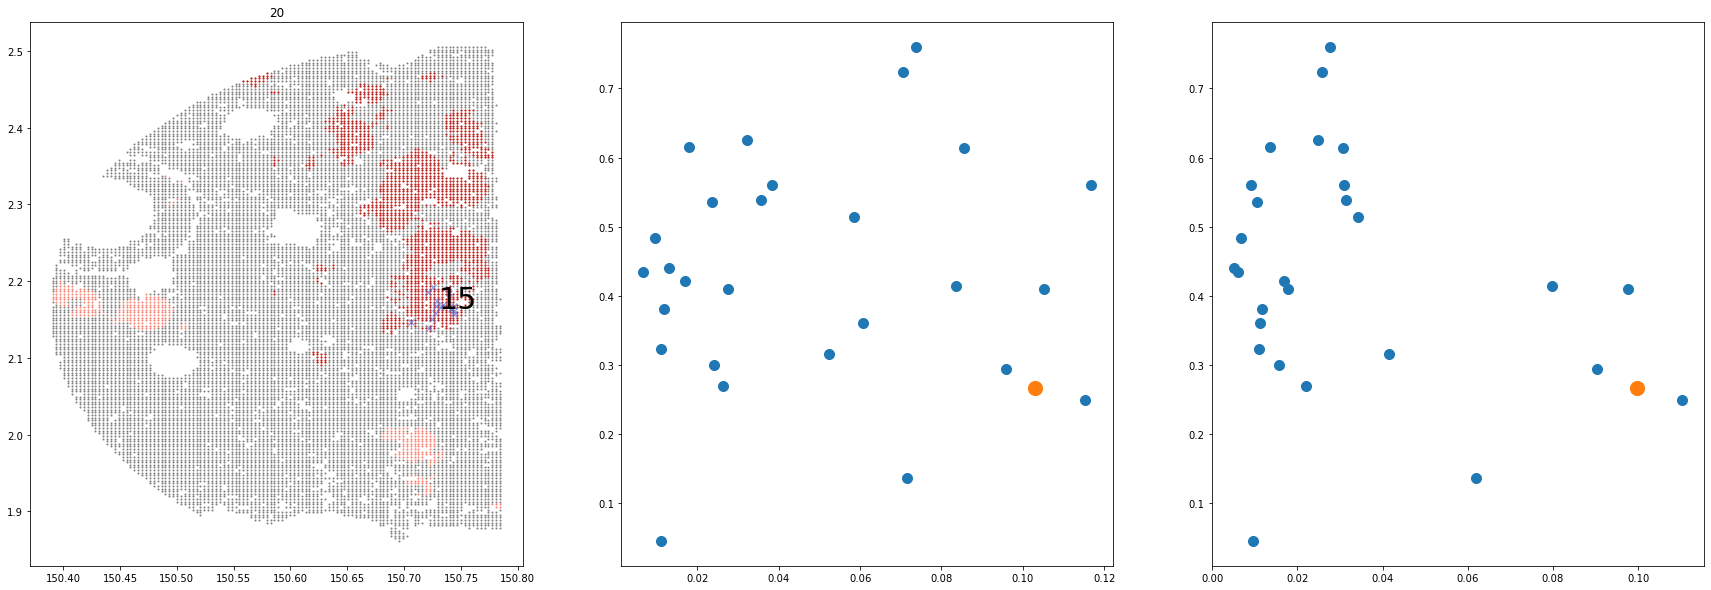

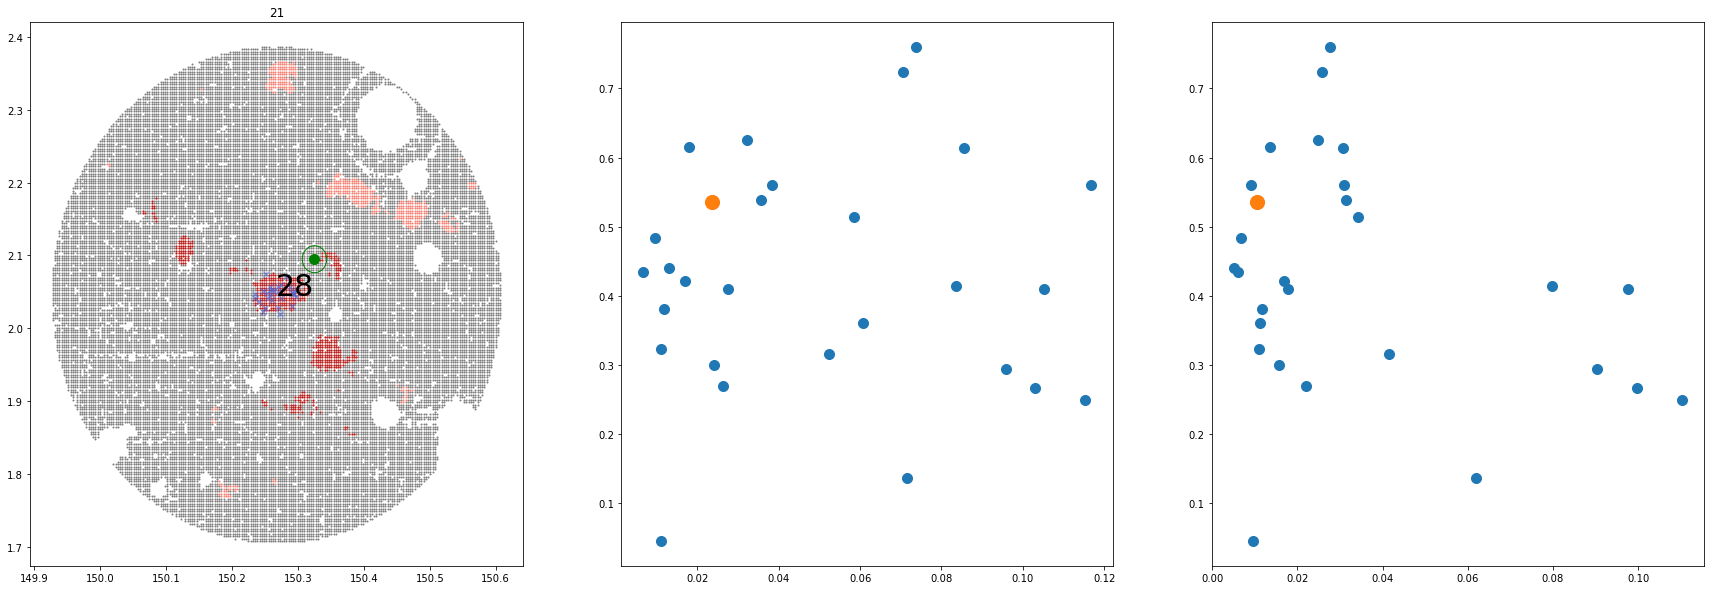

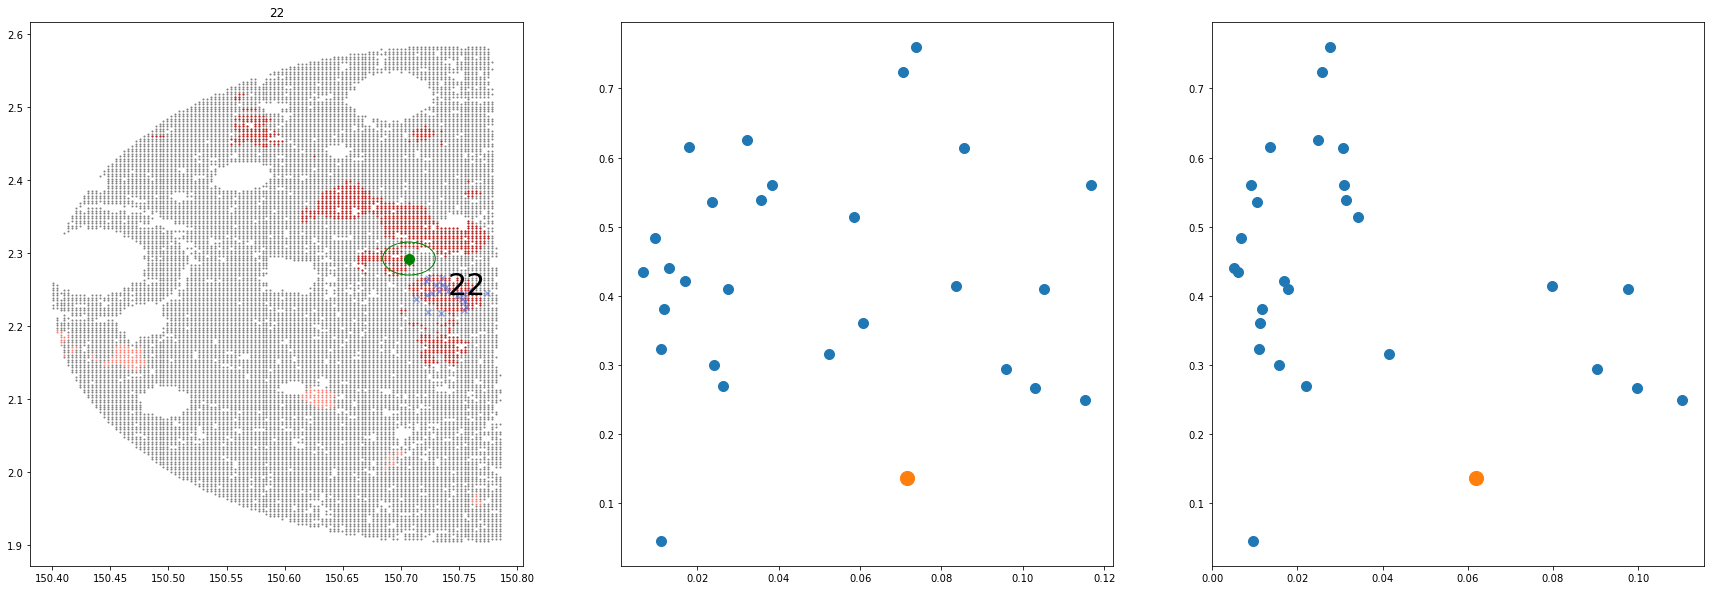

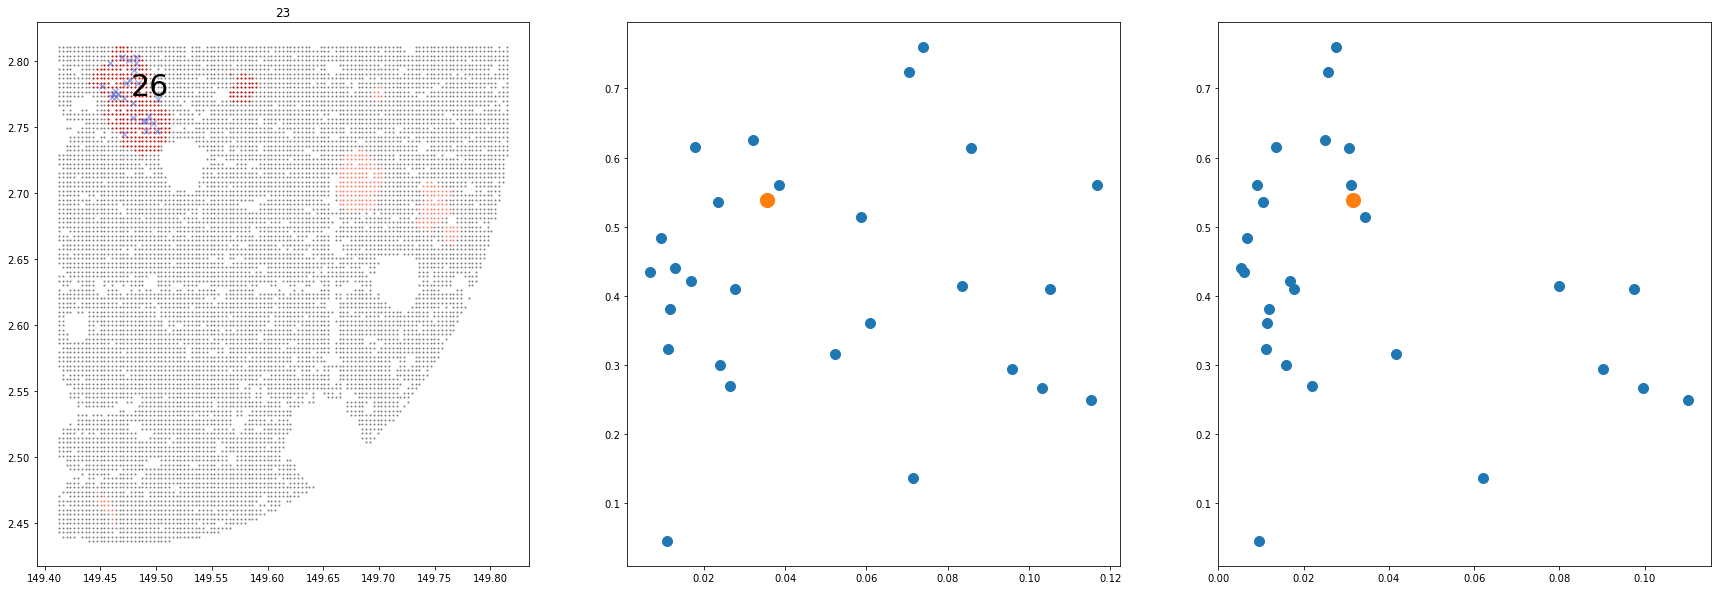

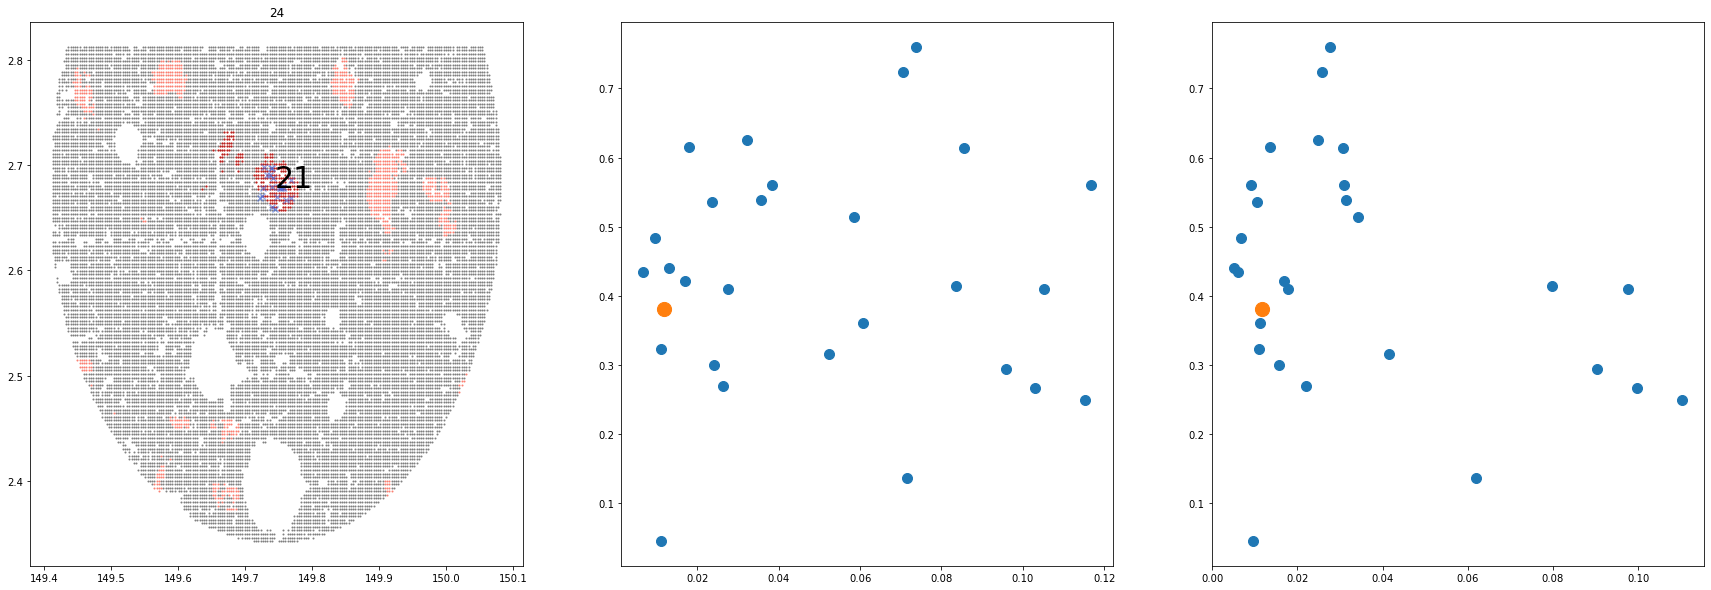

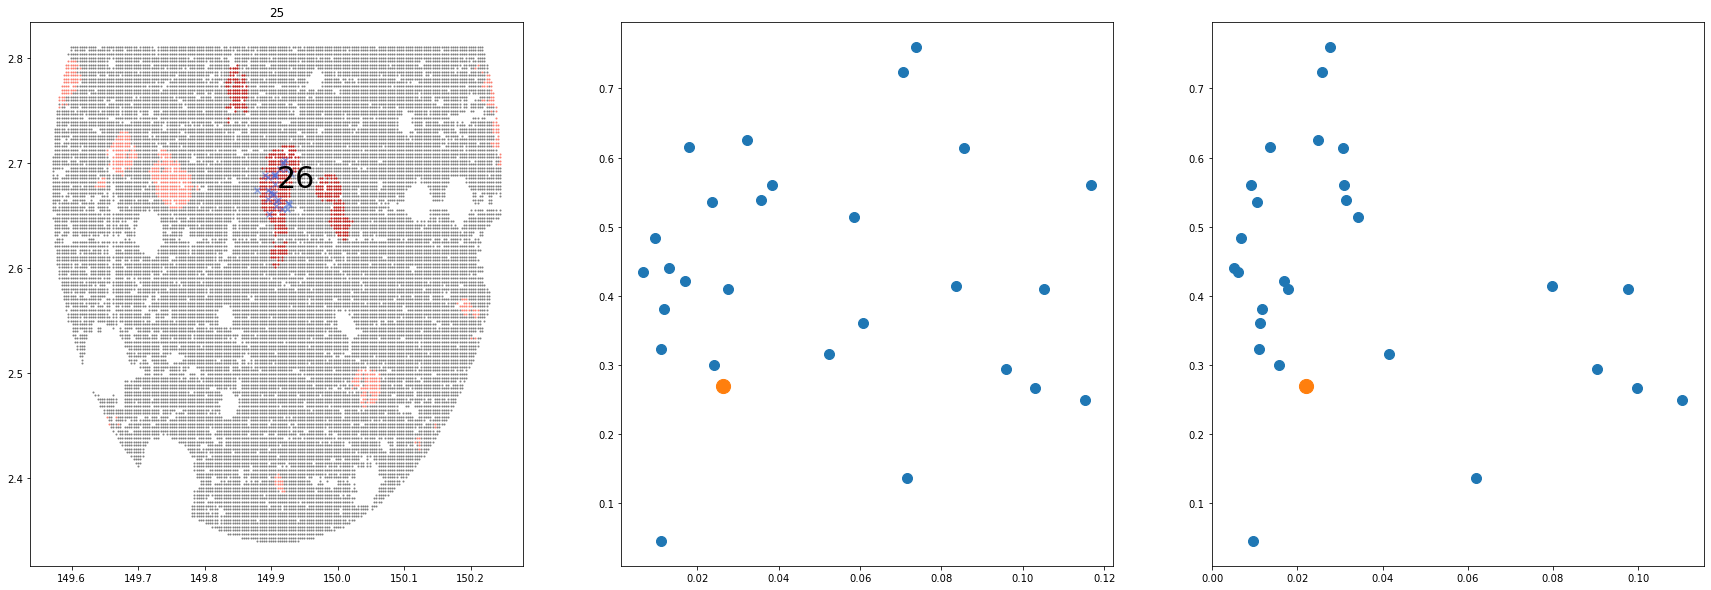

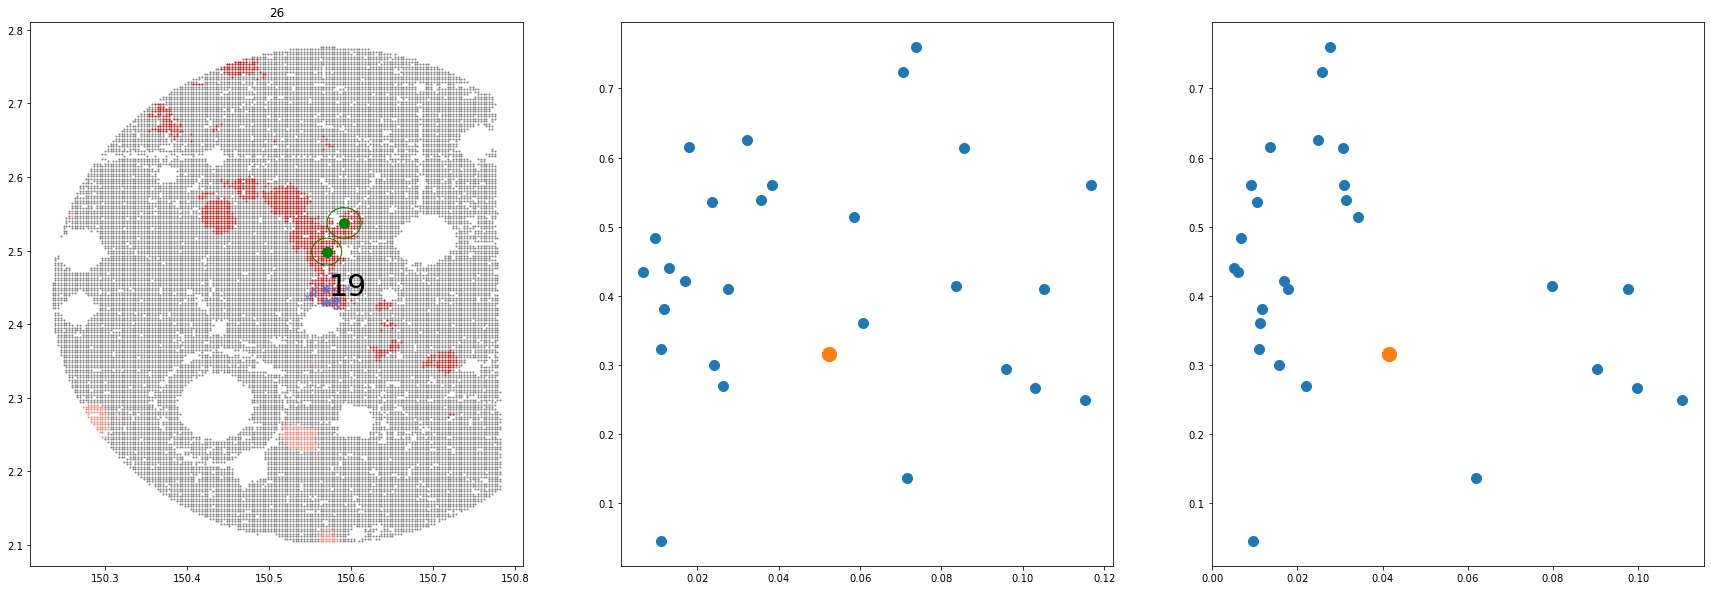

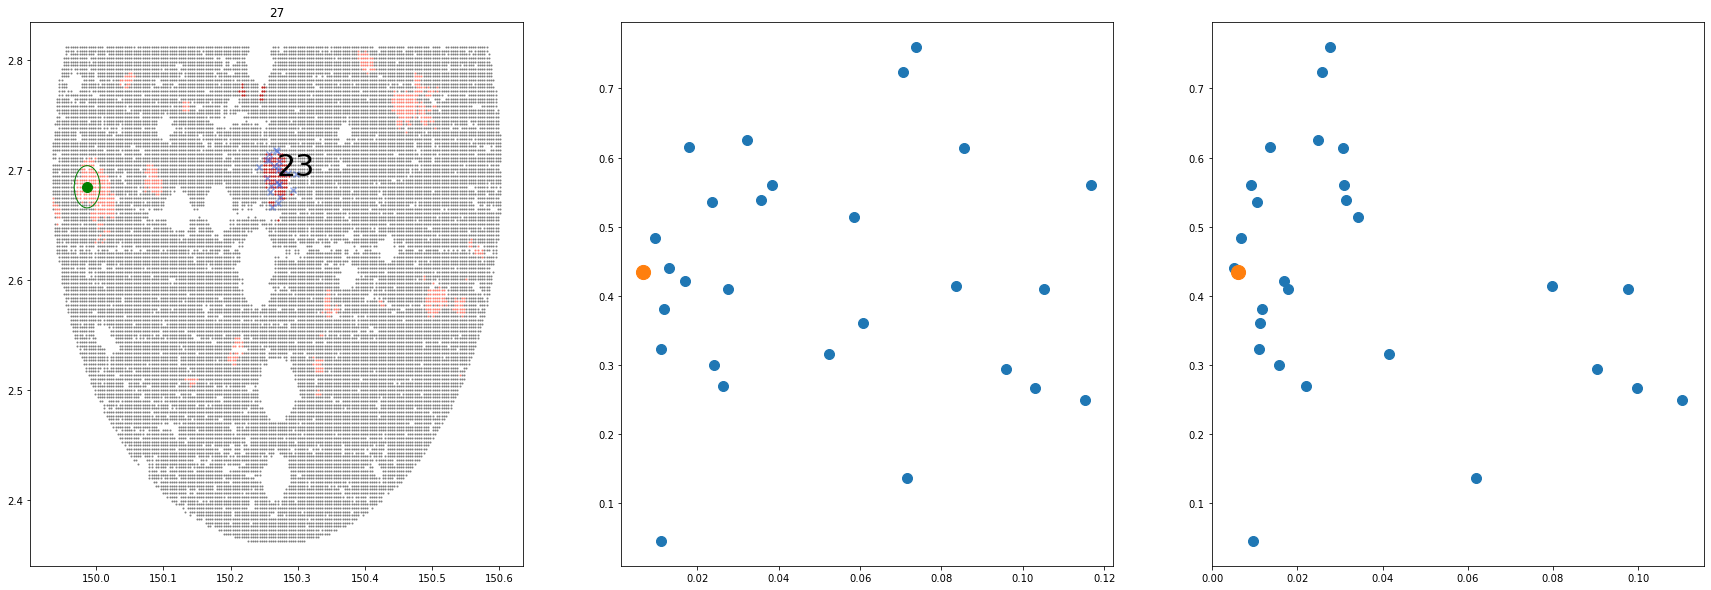

In [126]:
for i in range(len(ods)):
    mmask = total_pd['Seq'].isin(ods[i])
    
    mems = total_pd[mmask]
    z = np.mean(mems['zphot'])
    
    z_index = np.argmin((redshifts - z)**2) 
    
    grid = np.load('./bins/bins_cosmos/search_700kpc/' + file_list[z_index])
    mask1 = np.load('./bins/bins_cosmos/search_700kpc/mask1_10/' + mask1_list[z_index])
    mask2 = np.load('./bins/bins_cosmos/search_700kpc/mask2_10/' + mask2_list[z_index])

    grid_x = np.load('./bins/bins_cosmos/search_700kpc/grid_x/' + xlist[z_index])
    grid_y = np.load('./bins/bins_cosmos/search_700kpc/grid_y/' + ylist[z_index])
    
    grid_1d = grid[mask1 & mask2]

    mean = grid_1d.mean()
    std = grid_1d.std()

    overdense_mask2 = grid > mean + 2 * std
    sparse_mask2 = grid < mean + 2 * std
    
    grid_od = (grid - mean) / std

    search = find_radius(z, 10)
    area_mask = ((grid_x - np.mean(mems['RAJ2000']))**2 + (grid_y - np.mean(mems['DEJ2000']))**2 < search**2)
    
    fig, ax = plt.subplots(1, 3, figsize = (30, 10))
    ax[0].scatter(grid_x[mask1 & mask2 & area_mask&sparse_mask2], grid_y[mask1 & mask2 & area_mask& sparse_mask2], color = 'grey', s = 1)
    ax[0].scatter(grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask& overdense_mask2], color = 'salmon', s = 1)
    
    ax[0].set_title(f'{i}')
    
    findex = find_fofs(np.mean(mems['RAJ2000']), np.mean(mems['DEJ2000']), grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask&overdense_mask2], z_index, 2)    
    findex1 = find_fofs(np.mean(mems['RAJ2000']), np.mean(mems['DEJ2000']), grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask&overdense_mask2], z_index,1)    
    

    fof = len(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex]) / len(grid_x[mask1 & mask2 & area_mask])
    fof1 = len(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex1]) / len(grid_x[mask1 & mask2 & area_mask])
    
    ax[0].scatter(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex], grid_y[mask1 & mask2 & area_mask & overdense_mask2][findex], color = 'firebrick', alpha = 1, s = 1)

    ax[0].scatter(mems['RAJ2000'], mems['DEJ2000'], color = 'royalblue', marker = 'x', alpha = .5)
    
    xzmask = (x_new['redshift'] >= z- 0.02) & (x_new['redshift'] <= z + 0.02)
    xmask2 = (x_new['Ra'] - np.mean(mems['RAJ2000']))**2 + (x_new['Dec'] - np.mean(mems['DEJ2000']))**2 < search**2
    xsample = x_new[xzmask & xmask2]
    for k in range(len(xsample)):

        ax[0].scatter(xsample['Ra'][k], xsample['Dec'][k], s = 100, color = 'green')
        circle = plt.Circle((xsample['Ra'][k], xsample['Dec'][k]), xsample['R200_deg'][k], fill = False, color = 'green')
        ax[0].add_patch(circle)
    
    bzmask = (bellagamba['z'] >= z - 0.02) & (bellagamba['z'] <= z + 0.02)
    bmask2 = (bellagamba['RAJ2000'] - np.mean(mems['RAJ2000']))**2 + (bellagamba['DEJ2000'] - np.mean(mems['DEJ2000']))**2 < search**2
    bsample = bellagamba[bzmask & bmask2]
    ax[0].scatter(bsample['RAJ2000'], bsample['DEJ2000'], s = 100, color = 'yellow')

    age = cosmo.age(np.mean(mems['zphot'])).to(u.yr).value
    ssfr_mask  = 10**mems['sSFR'] < 1 / 3 / age
    
    ssfr = mems[ssfr_mask]
    
    fq = len(ssfr) / len(mems)
  
    ax[1].scatter(fofs, fqs_ssfr, s = 100)
    ax[1].scatter(fof, fq, s = 200)
    
    ax[2].scatter(fofs1, fqs_ssfr, s = 100)
    ax[2].scatter(fof1, fq, s = 200)
    
    ax[0].text(np.mean(mems['RAJ2000']), np.mean(mems['DEJ2000']), f'{len(mems)}', fontsize = 30)
    
    plt.savefig(f'candidates/members/figures/fof-fq/od{i}.png')

In [127]:
ras = []
decs = []
zs = []

for i in range(len(ods)):
    mmask = total_pd['Seq'].isin(ods[i])
    
    mems = total_pd[mmask]
    z = np.mean(mems['zphot'])
    zs.append(z)
    
    ra = np.mean(mems['RAJ2000'])
    ras.append(ra)
    
    dec = np.mean(mems['DEJ2000'])
    decs.append(dec)
    
ras = np.array(ras)
decs = np.array(decs)
zs = np.array(zs)

In [128]:
closes = []
for i in range(len(ods)):
    ra = ras[i]
    dec = decs[i]
    
    search = find_radius(zs[i], 3)
    mask = (ras - ra)**2 + (decs - dec)**2 < search**2
    mask2 = (zs > zs[i] - 0.1) & (zs < zs[i] + 0.1)
    
    close = [i]
    
    close.extend(np.where(mask & mask2)[0].tolist())
    
    if len(close) != 2:
    
        closes.append(np.unique(close).tolist())
    

In [129]:
closes

[[3, 6, 11],
 [4, 5],
 [4, 5],
 [3, 6],
 [7, 14],
 [3, 11],
 [7, 14],
 [20, 22],
 [20, 22]]

In [143]:
# zs

# characteristics of the muiltistructures

In [130]:
mras = []
mdecs = []
mzs = []
mmems = []
for i in range(9):
    mul = np.load(f'candidates/members/multi{i}.npy', allow_pickle = True)
    
    seqs = np.concatenate(mul)
    seqs = np.unique(seqs)
    seqs = list(seqs)
    seqs = [int(x) for x in seqs]
    
    mask = total_pd['Seq'].isin(seqs)
    mems = total_pd[mask]
    
    mras.append(np.mean(mems['RAJ2000']))
    mdecs.append(np.mean(mems['DEJ2000']))
    mzs.append(np.mean(mems['zphot']))
    mmems.append(seqs)

In [146]:
num_mems = [len(x) for x in mmems]

In [148]:
# num_mems

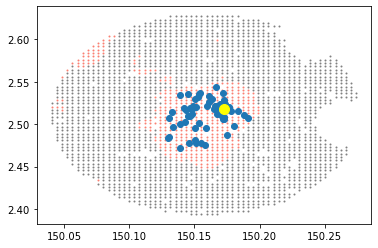

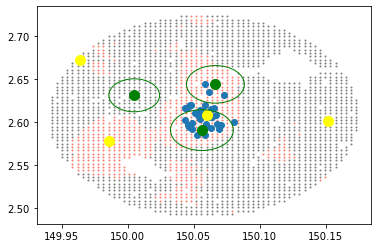

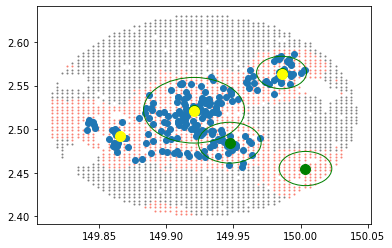

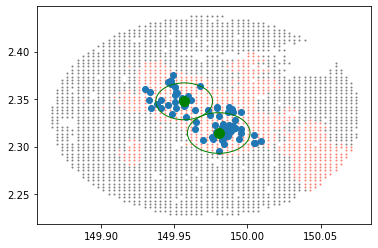

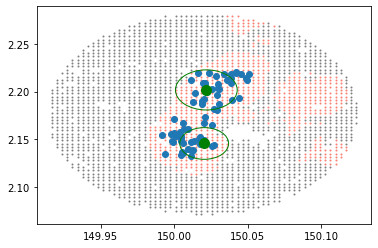

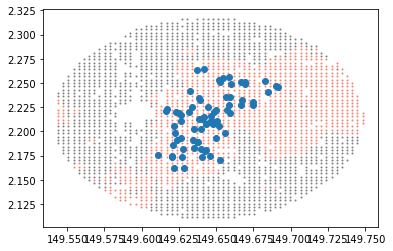

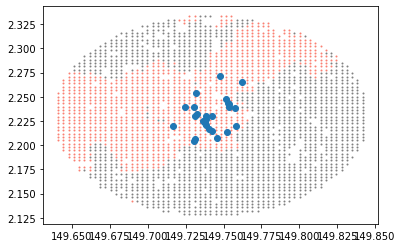

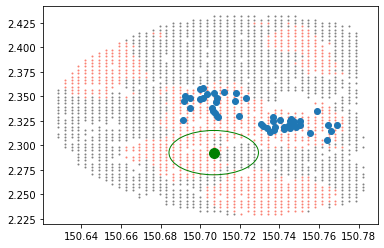

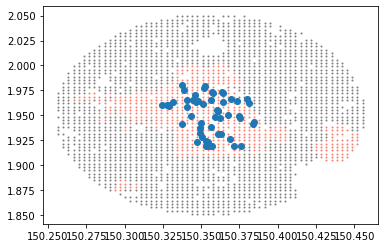

In [152]:
# mfofs = []

for i in range(9):
    
    mask = total_pd['Seq'].isin(mmems[i])
    mems = total_pd[mask]
    
    fig, ax = plt.subplots()
    
    z = np.mean(mems['zphot'])
    
    z_index = np.argmin((redshifts - z)**2) 
    
    grid = np.load('./bins/bins_cosmos/search_700kpc/' + file_list[z_index])
    mask1 = np.load('./bins/bins_cosmos/search_700kpc/mask1_10/' + mask1_list[z_index])
    mask2 = np.load('./bins/bins_cosmos/search_700kpc/mask2_10/' + mask2_list[z_index])

    grid_x = np.load('./bins/bins_cosmos/search_700kpc/grid_x/' + xlist[z_index])
    grid_y = np.load('./bins/bins_cosmos/search_700kpc/grid_y/' + ylist[z_index])
    
    grid_1d = grid[mask1 & mask2]

    mean = grid_1d.mean()
    std = grid_1d.std()

    overdense_mask2 = grid > mean + 2 * std
    sparse_mask2 = grid < mean + 2 * std
    
    grid_od = (grid - mean) / std

    search = find_radius(z, 3)
    area_mask = ((grid_x - np.mean(mems['RAJ2000']))**2 + (grid_y - np.mean(mems['DEJ2000']))**2 < search**2)

    ax.scatter(grid_x[mask1 & mask2 & area_mask&sparse_mask2], grid_y[mask1 & mask2 & area_mask& sparse_mask2], color = 'grey', s = 1)
    ax.scatter(grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask& overdense_mask2], color = 'salmon', s = 1)
 
    
    ax.scatter(mems['RAJ2000'], mems['DEJ2000'])

    
    xzmask = (x_new['redshift'] >= mzs[i] - 0.02) & (x_new['redshift'] <= mzs[i] + 0.02)
    xmask2 = (x_new['Ra'] - mras[i])**2 + (x_new['Dec'] - mdecs[i])**2 < search**2
    xsample = x_new[xzmask & xmask2]
    for k in range(len(xsample)):

        ax.scatter(xsample['Ra'][k], xsample['Dec'][k], s = 100, color = 'green')
        circle = plt.Circle((xsample['Ra'][k], xsample['Dec'][k]), xsample['R200_deg'][k], fill = False, color = 'green')
        ax.add_patch(circle)
    
    bzmask = (bellagamba['z'] >= mzs[i] - 0.02) & (bellagamba['z'] <= mzs[i] + 0.02)
    bmask2 = (bellagamba['RAJ2000'] - mras[i])**2 + (bellagamba['DEJ2000'] - mdecs[i])**2 < search**2
    bsample = bellagamba[bzmask & bmask2]
    ax.scatter(bsample['RAJ2000'], bsample['DEJ2000'], s = 100, color = 'yellow')
    
#     findex = find_fofs(np.mean(mems['RAJ2000']), np.mean(mems['DEJ2000']), grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask&overdense_mask2], z_index, 0.5)    


#     fof = len(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex]) / len(grid_x[mask1 & mask2 & area_mask])
#     mfofs.append(fof)

In [137]:
mfqs = []
mfqs_ssfr = []

for i in range(9):
    mmask = total_pd['Seq'].isin(mmems[i])
    
    mems = total_pd[mmask]
    
    fq = 1 - sum(mems['Cl']) / len(mems)
    mfqs.append(fq)
    
    age = cosmo.age(np.mean(mems['zphot'])).to(u.yr).value
    ssfr_mask  = 10**mems['sSFR'] < 1 / 3 / age
    
    ssfr = mems[ssfr_mask]
    
    fq2 = len(ssfr) / len(mems)
    mfqs_ssfr.append(fq2)

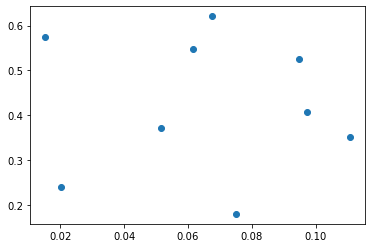

In [139]:
plt.scatter(mfofs, mfqs_ssfr)
# plt.scatter(fofs, fqs_ssfr)

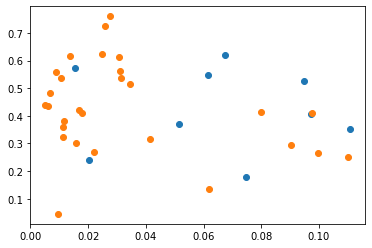

In [144]:
plt.scatter(mfofs, mfqs_ssfr)
plt.scatter(fofs1, fqs_ssfr)